In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
import seaborn as sns
import cmyt 
import utils_hb as hb

from matplotlib import transforms
from matplotlib.lines import Line2D
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize
from ipywidgets import interactive
from tqdm import tqdm
from cycler import cycler


# Matplotlib settings
font = {'family' : 'serif',
        #'weight' : 'bold',
        'size'   : 14}

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rc('axes', prop_cycle=(cycler('color', ['#8F59C7', '#00BF9B', '#EC5F9B','#7D787A','#83C8E0','grey'])))

sns.set_style('whitegrid')


# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# TLS Model Simulation

## Intra-cavity field simulations

The Langevin-Heisenberg equation of motion describing the system is

$$ \dot{a} = -i \omega_0 a - \dfrac{\kappa_0}{2} a - \dfrac{\kappa_{TLS}(a)}{2} \; a - \sqrt{\kappa_0^{ext}} a_{in}, $$

where $\omega_0$ represents the resonant frequency, $\kappa_0 = \kappa_0^{int} + \kappa_0^{ext}$ is the loss rate, $\kappa^{ext}$ the external coupling to the drive port, $\kappa_{TLS}$ the TLS damping, and $\hat{a}$ and $\hat{a}_{in}$ are the time-dependent annihilation operators for the internal mode and the input drive, respectively.
        
We consider a TLS damping term of the following form

$$ \kappa_{TLS}(a) = \dfrac{\kappa_{TLS}}{\left[1 + \left( \dfrac{|a|}{a_c}\right)^2 \right]^\beta}, $$

where $\kappa_{TLS}$ represents the losses due to the parasitic TLS, and $|a_c|^2$ te critical photon number.
We also consider two drives of the form:

$$ a_{in} = F_1 e^{-i\omega_1 t} + F_2 e^{-i(\omega_2 t + \varphi)}. $$

In [3]:
# PARAMETERS

# resonator parameters
f0 = 0.000  # resonant frequency
kint = 0.01
kext = 0.07
k0 = kint + kext  # linear dissipation
ktls = 0.04  # TLS non-linear dissipation
ac = np.sqrt(2)
beta = 0.3

# drive parameters
F01 = 0.5  # drive 1 amplitude
F02 = F01  # drive 2 amplitude
fd1 = -0.001  # drive 1 frequency
fd2 = 0.001   # drive 2 frequency
psi = -0.5 * np.pi

# environment parameters
alpha = np.pi / 5
delta = np.pi / 4
phase_delay = 0 #delta - alpha  # phase delay between the input and output fields
gain = 1  # Output line gain
att = 1  # input line attenuation

# inital state
y0 = [1, 0]

# Integration parameters
df = 0.001
fs = 15
N = int(round(fs/df))
T = 1. / df
T_relax = 5 * T
dt = 1. / fs
time = dt * (np.arange((T + T_relax) / dt) + 1)

# Q factor
Q = 2 * np.pi * f0 / (2 * k0)  # Quality factor
print('\033[1m' + 'Q factor: ' + '\033[0m' + f'{Q:.2f}' )

Q factor: 0.00


We then solve numerically the differential equation, obtaining the following fields:

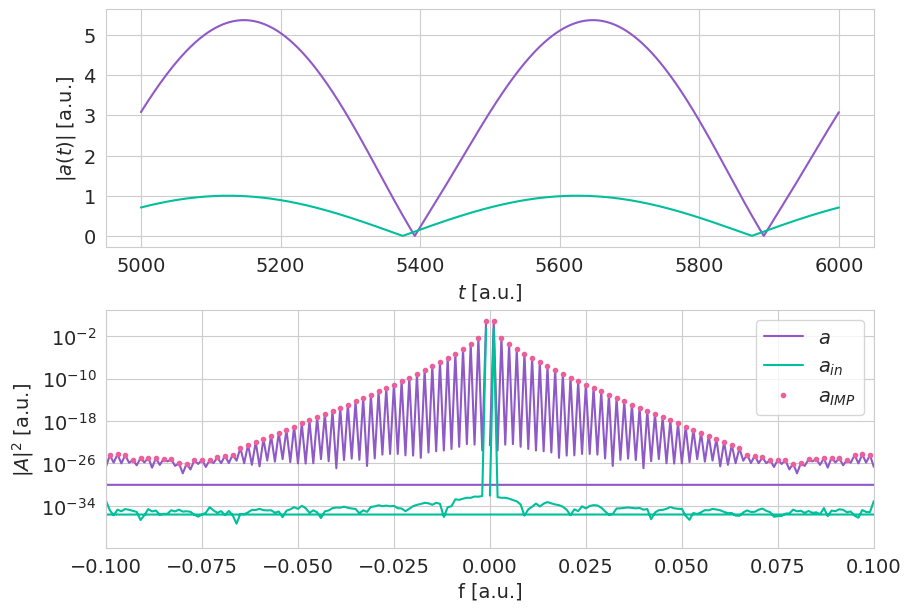

In [4]:
# Intra-cavity field

# run the integrator
A, a, f, t = hb.tls_simulation(time_=time,
                               f0_=f0,
                               k0_=k0,
                               ktls_=ktls,
                               ac_=ac,
                               beta_=beta,
                               F1_=F01,
                               F2_=F02,
                               fd1_=fd1,
                               fd2_=fd2,
                               kext_=kext,
                               psi_=psi,
                               y0_=y0,
                               N_=N,
                               dt_=dt,
                               )


# Drives 
ain = F01 * np.exp(-1j * 2 * np.pi * fd1 * t) + F02 * np.exp(-1j * (2 * np.pi * fd2 * t + psi))
Ain = np.fft.fft(ain) / len(ain)

# IMPs indices
drives_ind = -np.array([int(fd1 / df), int(fd2 / df)])
nimps = 100
nstep = int((fd2 - fd1) / df)
imps_ind = np.arange(drives_ind[1] - nimps*nstep, drives_ind[0] + nimps*nstep + nstep, nstep)


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.abs(a))
ax[0].plot(t, np.abs(ain))
ax[1].semilogy(f, np.abs(A)**2, label=r'$a$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$a_{in}$')
ax[1].semilogy(f[imps_ind], np.abs(A)[imps_ind]**2, '.', label=r'$a_{IMP}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$|a(t)|$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

In [5]:
np.abs(A)[51]

2.9161413860271134e-10

## Harmonic balance reconstruction by pseudomatrix inversion

We now want to recover the parameters using harmonic balance.
We then first expand the square root of the TLS non-linear damping term as

$$ \dfrac{\kappa_{TLS}(a)}{2} = \dfrac{ ^{\kappa_{TLS}}/2}{\left[1+ \left( |a|/a_c \right)^2\right]^\beta} = \dfrac{\kappa_{TLS}}{2} \left( 1 - \beta \left( \dfrac{|a|}{a_c} \right)^2 + \dfrac{1}{2} \beta (\beta+1) \left( \dfrac{|a|}{a_c} \right)^4 + \mathcal{O}(|a|^6) \right) = c_1 + c_3 |a|^2 + c_5 |a|^4 + \mathcal{O}(|a|^6) $$

Thus, the equation of motion is given by:

$$ \dot{a} = -i \omega_0 a - \left( \dfrac{\kappa_0}{2} + c_1 \right) a - c_3 \left| a \right|^2 a - c_5 \left| a \right|^4 a - \cdot \cdot \cdot - c_n \left| a \right|^{n-1} a - \sqrt{\kappa_0^{ext}} a_{in}$$

We then Fourier transform the equation of motion obtaining:

$$ i \omega_k A_k + i \omega_0 A_k + \left( \dfrac{\kappa_0}{2} + c_1 \right) A_k + c_3 \mathscr{F} \left\{ \left| a \right|^2 a \right\}_k + c_5 \mathscr{F} \left\{ \left| a \right|^4 a \right\}_k + \cdot \cdot \cdot + c_n \mathscr{F} \left\{ \left| a \right|^{n-1} a \right\}_k = -\sqrt{\kappa_0^{ext}} A_{in,k}$$

$$ i \omega_k A_k + i \omega_0 A_k + c_1' A_k + c_3 \mathscr{F} \left\{ \left| a \right|^2 a \right\}_k + c_5 \mathscr{F} \left\{ \left| a \right|^4 a \right\}_k + \cdot \cdot \cdot + c_n \mathscr{F} \left\{ \left| a \right|^{n-1} a \right\}_k = -\sqrt{\kappa_0^{ext}} A_{in,k}$$

In matrix form:

$$ \begin{pmatrix} i \omega_k A_k & i A_k & A_k & \mathscr{F} \left\{ \left| a \right|^2 a \right\}_k & \mathscr{F} \left\{ \left| a \right|^4 a \right\}_k & \dots &  \mathscr{F} \left\{ \left| a \right|^{2n} a \right\}_k\end{pmatrix} 
\begin{pmatrix} 1/\sqrt{\kappa_0^{ext}} \\ \omega_0/\sqrt{\kappa_0^{ext}} \\ c_1'/\sqrt{\kappa_0^{ext}} \\ c_3/\sqrt{\kappa_0^{ext}} \\ \vdots \\ c_n/\sqrt{\kappa_0^{ext}} \end{pmatrix} = -A_{in,k}. $$

In this way, we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain the least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

To check how many terms we need in the reconstruction, we first simulate the damping term (blue line in the following figure) given by

$$ \dfrac{1}{2} \left(\kappa_0 + \dfrac{ \kappa_{TLS}}{\left[1+ \left( |a|/a_c \right)^2\right]^\beta} \right), $$

and we then fit a polynomial (red line in the following figure)

$$ c_1' + c_3 |a|^2 + c_5 |a|^4 + \mathcal{O}(|a|^6). $$

Depending on the range of |a| we will need more or less polynmial coefficients to properly fit the TLS damping.
We are interested in small |a|.

In [6]:
# TLS damping function
def tls_function(x, κ0_, κtls_, ac_, beta_):
    return κ0_ / 2 + κtls_ / 2 / (1 + (np.abs(x) / ac_)**2)**beta_

FIT PARAMETERS
c1 = 5.999e-02
c3 = -2.922e-03
c5 = 7.942e-04
c7 = -1.863e-04
c9 = 3.184e-05
c11 = -3.781e-06
c13 = 3.085e-07
c15 = -1.715e-08
c17 = 6.363e-10
c19 = -1.505e-11
c21 = 2.050e-13
c23 = -1.222e-15


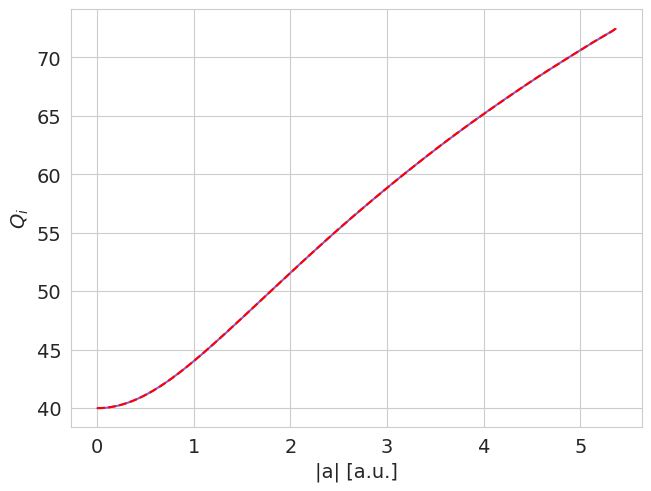

In [7]:
# We simulate the TLS non-linearity
xmax = np.max(np.abs(a))
x_sim = np.linspace(0, xmax, 10000)
y_sim = tls_function(x_sim, k0, ktls, ac, beta)

# Polynomial fit up to nth order
n = np.arange(0, 23, 2)
coefficients = np.polynomial.polynomial.polyfit(x_sim, y_sim, n)

# Fit data
y_fit = 0
print('\033[1m' + 'FIT PARAMETERS' + '\033[0m')
for coef_ind, coef_val in enumerate(coefficients):
    y_fit += coef_val * x_sim ** coef_ind
    if coef_ind%2 == 0:
        print(f'c{coef_ind+1} = {coef_val:.3e}')


# Plot
fig7, ax7 = plt.subplots(1)

ax7.plot(x_sim, 1 / (y_sim - kext/2))
ax7.plot(x_sim, 1 / (y_fit - kext/2), 'r--')
ax7.set_xlabel('|a| [a.u.]')
ax7.set_ylabel(r'$Q_i$')

plt.show()

We calculate the residual between the polynomial expansion and the actual TLS function to estimate the number of polynomial terms we need.

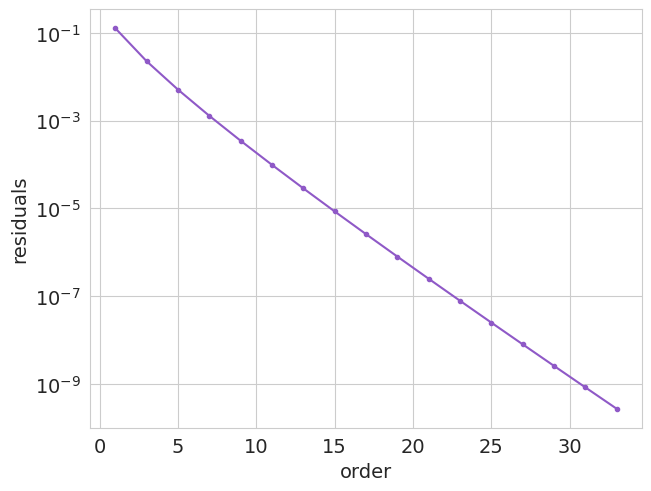

In [8]:
n_arr = np.arange(1, 35, 2)
residuals = np.zeros(len(n_arr))

for n_idx, n_val in enumerate(n_arr):
    nn = np.arange(0, n_val, 2)
    coefficients, fit_params = np.polynomial.polynomial.polyfit(x_sim, y_sim, nn, full=True)
    residuals[n_idx] = fit_params[0]


# plot of the residuals
fig, ax = plt.subplots()

ax.semilogy(n_arr, residuals, '.-')

ax.set_ylabel('residuals')
ax.set_xlabel('order')

plt.show()

We then insert our simulated (only the IMP frequencies with good signal-to-noise ratio) data into the harmonic balance algorithm, obtaining:

In [9]:
# Reconstruction using the complex time-domain spectra
kext_rec, f0_rec, d_rec, Q_fit = hb.tls_reconstruction(A, Ain, a, ain, f, imps_ind, n)

# Daniel's idea
kext_rec_d, f0_rec_d, d_rec_d, _ = hb.tls_reconstruction(A, Ain, a, ain, f, imps_ind, n, daniel=True)

# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15} {:<15}'.format('Parameter', 'Simulation', 'Reconstruction 1', 'Reconstruction 2') + '\033[0m')
print('{:<15} {:<15} {:<15} {:<15}'.format('kext', f'{kext:.3e}', f'{kext_rec:.3e}', f'{kext_rec_d:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('f0', f'{f0:.3e} Hz', f'{f0_rec:.3e} Hz', f'{f0_rec_d:.3e} Hz'))
print('{:<15} {:<15} {:<15} {:<15}'.format('c1', f'{coefficients[0]:.3e}', f'{d_rec[0]:.3e}', f'{d_rec_d[0]:.3e}'))
for order_ind, order_val in enumerate(n[:-1]):
    print('{:<15} {:<15} {:<15} {:<15}'.format(f'c{order_val+3}', f'{coefficients[order_val+2]:.3e}', f'{d_rec[order_ind+1]:.3e}', f'{d_rec_d[order_ind+1]:.3e}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction 1 Reconstruction 2
kext            7.000e-02       7.000e-02       7.000e-02      
f0              0.000e+00 Hz    -2.247e-15 Hz   -2.010e-15 Hz  
c1              6.000e-02       5.996e-02       5.996e-02      
c3              -2.991e-03      -2.816e-03      -2.816e-03     
c5              9.389e-04       6.935e-04       6.935e-04      
c7              -3.098e-04      -1.426e-04      -1.426e-04     
c9              8.902e-05       2.134e-05       2.134e-05      
c11             -2.031e-05      -2.245e-06      -2.245e-06     
c13             3.549e-06       1.644e-07       1.644e-07      
c15             -4.700e-07      -8.307e-09      -8.307e-09     
c17             4.711e-08       2.832e-10       2.832e-10      
c19             -3.575e-09      -6.209e-12      -6.209e-12     
c21             2.048e-10       7.900e-14       7.900e-14      
c23             -8.783e-12      -4.429e-16      -4.429e-16     


We now fit the TLS damping function to the reconstructed polynomial expansion in order to recover the initial parameters of the model.

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction 1 Reconstruction 2
kext            7.00000e-02     7.00000e-02     7.00000e-02    
f0              0.00000e+00     -2.24682e-15    -2.01017e-15   
κ0              8.00000e-02     8.08225e-02     8.08225e-02    
κtls            4.00000e-02     3.91272e-02     3.91272e-02    
ac              1.41421e+00     1.44154e+00     1.44154e+00    
β               3.00000e-01     3.13350e-01     3.13350e-01    


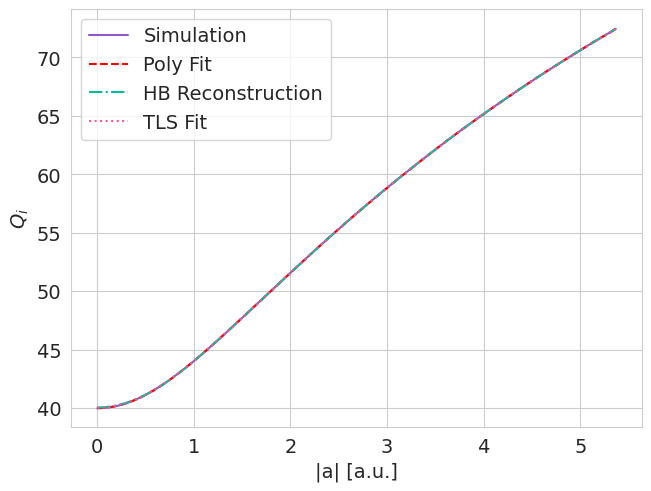

In [10]:
# Reconstructed damping using complex time-domain spectra
y_recon = 0
for coef_ind, coef_val in enumerate(d_rec):
    y_recon += coef_val * x_sim**(2 * coef_ind)
    
y_recon_d = 0
for coef_ind, coef_val in enumerate(d_rec_d):
    y_recon_d += coef_val * x_sim**(2 * coef_ind)

# curve fit of the reconstructed damping to get the tls parameters
popt = curve_fit(tls_function, x_sim, y_recon,
                 p0=[k0, ktls, ac, beta])

param_rec_hb = np.append(f0_rec, [*popt[0], kext_rec])

popt = curve_fit(tls_function, x_sim, y_recon_d,
                 p0=[k0, ktls, ac, beta])

param_rec_hb_d = np.append(f0_rec_d, [*popt[0], kext_rec_d])

print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15} {:<15}'.format('Parameter', 'Simulation', 'Reconstruction 1', 'Reconstruction 2') + '\033[0m')
print('{:<15} {:<15} {:<15} {:<15}'.format('kext', f'{kext:.5e}', f'{kext_rec:.5e}', f'{kext_rec_d:.5e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('f0', f'{f0:.5e}', f'{f0_rec:.5e}', f'{f0_rec_d:.5e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('κ0', f'{k0:.5e}', f'{param_rec_hb[1]:.5e}', f'{param_rec_hb_d[1]:.5e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('κtls', f'{ktls:.5e}', f'{param_rec_hb[2]:.5e}', f'{param_rec_hb_d[2]:.5e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('ac', f'{ac:.5e}', f'{param_rec_hb[3]:.5e}', f'{param_rec_hb_d[3]:.5e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('β', f'{beta:.5e}', f'{param_rec_hb[4]:.5e}', f'{param_rec_hb_d[4]:.5e}'))


# Plotting
fig, ax = plt.subplots(1)

ax.plot(x_sim, 1 / (y_sim - kext/2), label='Simulation')
ax.plot(x_sim, 1 / (y_fit - kext/2), 'r--', label='Poly Fit')
ax.plot(x_sim, 1 / (y_recon - kext_rec/2), '-.', label='HB Reconstruction')
ax.plot(x_sim, 1 / (tls_function(x_sim, *popt[0]) - kext_rec/2), ':', label='TLS Fit')

ax.set_xlabel('|a| [a.u.]')
ax.set_ylabel(r'$Q_i$')
ax.legend()

plt.show()

As a sanity check, we solve again the equation of motion using the reconstructed parameters.

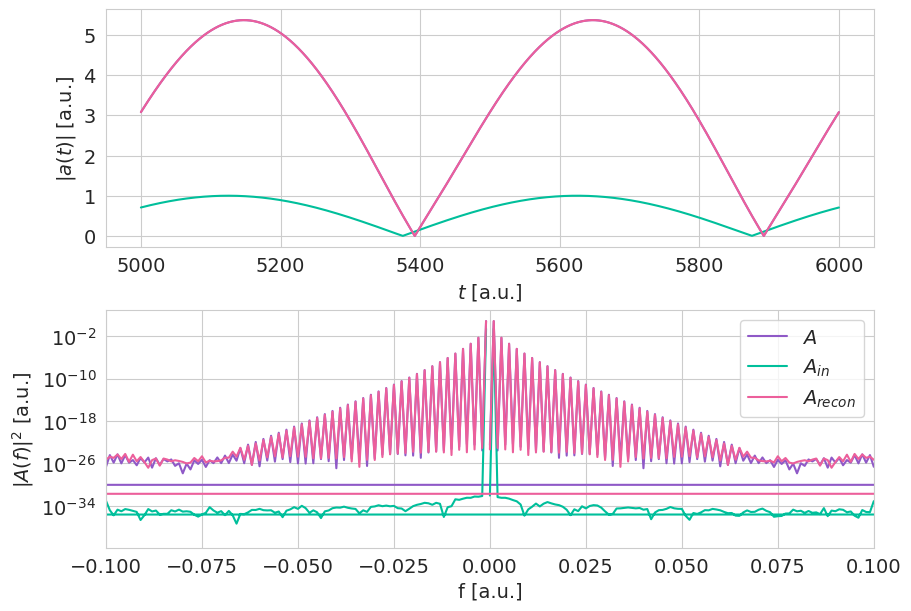

In [11]:
verbose = True

if verbose:

    # run the integrator
    A_rec, a_rec, _, _ = hb.tls_simulation(time_=time,
                                           f0_=f0_rec,
                                           k0_=popt[0][0],
                                           ktls_=popt[0][1],
                                           ac_=popt[0][2],
                                           beta_=popt[0][3],
                                           F1_=F01,
                                           F2_=F02,
                                           fd1_=fd1,
                                           fd2_=fd2,
                                           kext_=kext_rec,
                                           psi_=psi,
                                           y0_=y0,
                                           N_=N,
                                           dt_=dt,
                                           )


    # Plot: steady-state fields in the time and frequency domain
    fig, ax = plt.subplots(2, figsize=(9, 6))

    # plot
    ax[0].plot(t, np.abs(a))
    ax[0].plot(t, np.abs(ain))
    ax[0].plot(t, np.abs(a_rec))
    ax[1].semilogy(f, np.abs(A)**2, label=r'$A$')
    ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')
    ax[1].semilogy(f, np.abs(A_rec)**2, label=r'$A_{recon}$')

    # labels
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([-df*100, df*100])
    ax[1].legend()

    plt.show()

As a sanity check, I print the product $\bar{\bar{H}} \bar{p}$, which should be a matrix full of zeros, except for the two drives frequencies.

In [12]:
if verbose:
    print(Q_fit)

[ 7.14070531e-13 -4.09152352e-13  1.52892249e-13 -7.90342422e-14
  8.29048354e-13 -9.18179476e-13  5.65606250e-13  4.96054167e-13
 -4.54384231e-13 -2.21708115e-15  3.98782116e-13 -1.95462199e-13
  4.30170040e-13 -4.98607354e-13  5.88693569e-13 -3.28295384e-14
  6.76980852e-14  1.87782507e-13  1.14061859e-13 -2.59166323e-13
  7.54271491e-13 -6.80976362e-13  6.31815026e-13 -2.30066990e-13
  4.99324644e-13 -3.80419474e-13  4.88811615e-13  9.03993062e-14
  2.38337828e-14 -4.50606205e-13  7.51179059e-13  3.76448607e-14
 -3.58937736e-13  1.66419471e-13  9.80157903e-13 -1.01704974e-12
  8.36995302e-13 -1.04824541e-13 -1.47713738e-13  2.38102819e-13
  6.02700016e-13 -1.05105968e-12  8.13941174e-13 -3.56176571e-14
  2.03177746e-14 -3.74944827e-13  7.33413076e-13 -2.77580942e-13
 -1.45872612e-13  1.18429619e-13  5.00774491e-13 -4.22859093e-14
 -5.34495231e-13  9.75282334e-13 -2.52087273e-13 -1.60038779e-13
  1.91983878e-13 -8.53876290e-14  4.39512501e-13 -2.35530341e-13
  1.71153573e-13 -1.36769

## Harmonic balance reconstruction by spectrum fitting

Alternatively, we can use a different algorithm, based on fitting an arbitrary model to the measured data in the Fourier domain, to reconstruct the system parameters from the partial spectrum.

The equation of motion is again described by

$$ \dot{a} + i \omega_0 a + \dfrac{\kappa_0}{2} a + \dfrac{\kappa_{TLS}/2}{\left[1 + \left( \dfrac{|a|}{a_c}\right)^2 \right]^\beta} \; a + \sqrt{\kappa_0^{ext}} a_{in} = 0. $$

In the Fourier domain we have that

$$ i \omega A_k + i \omega_0 A_k + \dfrac{\kappa_0}{2} A_k + \mathscr{F} \left\{ \dfrac{\kappa_{TLS}/2}{\left[1 + \left( \dfrac{|a|}{a_c}\right)^2 \right]^\beta} \; a \right\}_k + \sqrt{\kappa_0^{ext}} A_{in, k} = 0. $$

We only measure few IMPs with good signal-to-noise ratio. Assuming then that the partial spectrum is an accurate representation of the whole spectrum we have

$$ i \omega A_k + i \omega_0 A_k + \dfrac{\kappa_0}{2} A_k + \mathscr{F} \left\{ \dfrac{\kappa_{TLS}/2}{\left[1 + \left( \dfrac{|a|}{a_c}\right)^2 \right]^\beta} \; a \right\}_k + \sqrt{\kappa_0^{ext}} A_{in, k} = \epsilon(p, k), $$

where $\epsilon$ is a vector where each component represents a residual at a given frequency $k$. Thus, the optimal parameters would be the ones that minimize each component of the vector $\epsilon$.

We perform two different numerical solvers (Nelder-Mead and Levenberg-Marquardt) to obtain the optimal parameters.


In [13]:
def error_func_nm(w):
    
    f0, k0, ktls, ac, beta, kext = w
    
    epsilon = (1.0j * 2 * np.pi * (f[imps_ind] + f0) * Apartial + 
               k0 / 2 * Apartial + 
               ktls / 2 * np.fft.fft(1 / (1 + (np.abs(apartial) / ac) ** 2) ** beta * apartial)[imps_ind] / len(apartial) +
               np.sqrt(kext) * Ain_partial
              )
        
    return(np.sum(np.real(epsilon)**2 + np.imag(epsilon)**2))


def error_func_ls(w):
    
    f0, k0, ktls, ac, beta, kext = w
    
    epsilon = (1.0j * 2 * np.pi * (f[imps_ind] + f0) * Apartial + 
               k0 / 2 * Apartial + 
               ktls / 2 * np.fft.fft(1 / (1 + (np.abs(apartial) / ac) ** 2) ** beta * apartial)[imps_ind] / len(apartial) +
               np.sqrt(kext) * Ain_partial
              )
        
    return(np.concatenate((np.real(epsilon), np.imag(epsilon))))

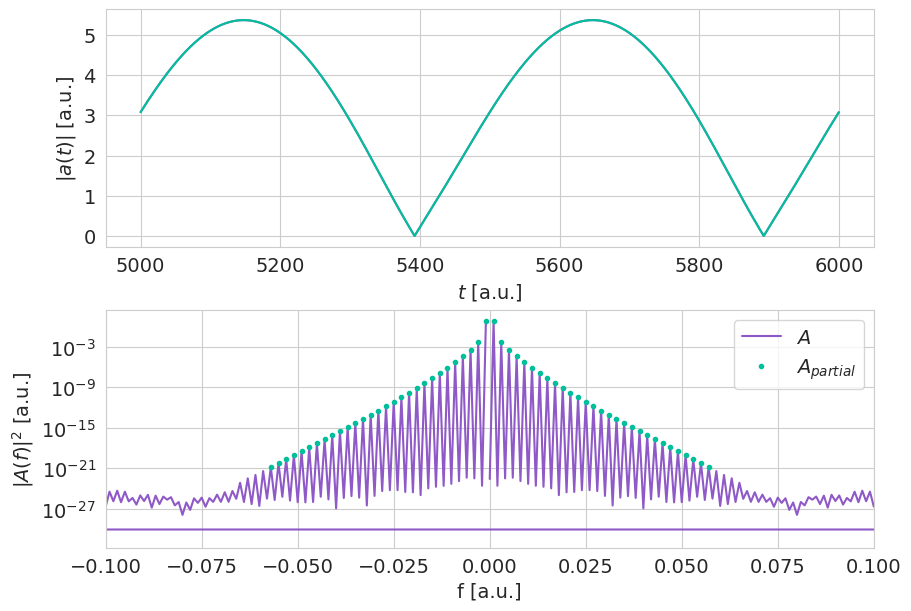

In [14]:
# Partial spectra for spectrum fitting reconstruction
verbose = True

# IMPs indices
drives_ind = -np.array([int(fd1 / df), int(fd2 / df)])
nimps = 28
nstep = int((fd2 - fd1) / df)
imps_ind = np.arange(drives_ind[1] - nimps*nstep, drives_ind[0] + nimps*nstep + nstep, nstep)

# partial spectra zero padded
Apartial_zp = np.zeros(len(A), dtype=complex)
Apartial_zp[imps_ind] = A[imps_ind]

# partial spectra in frequency and time domain
Apartial = A[imps_ind]
apartial = np.fft.ifft(Apartial_zp)
apartial *= len(apartial)
# partial input field
Ain_partial = Ain[imps_ind]

# frequencies of the partial spectra
f_partial = f[imps_ind]

# sanity check
if verbose:
# Plot: steady-state fields in the time and frequency domain
    fig, ax = plt.subplots(2, figsize=(9, 6))

    # plot
    ax[0].plot(t, np.abs(a))
    ax[0].plot(t, np.abs(apartial))
    ax[1].semilogy(f, np.abs(A)**2, label=r'$A$')
    ax[1].semilogy(f_partial, np.abs(Apartial)**2, '.', label=r'$A_{partial}$')

    # labels
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([-df*100, df*100])
    ax[1].legend()

    plt.show()

In [15]:
# Initial guess
x0 = param_rec_hb

# Nelder-Mead (nm) algorithm
res = scipy.optimize.minimize(error_func_nm, (x0), tol=1e-10)
param_rec_sf_nm = res.x

# least squares or Levenberg-Marquardt algorithm
res = scipy.optimize.least_squares(error_func_ls, x0)
param_rec_sf_ls = res.x

# residuals
error = error_func_nm([f0, k0, ktls, ac, beta, kext])
error_hb = error_func_nm(param_rec_hb)
error_sf_nm = error_func_nm(param_rec_sf_nm)
error_sf_ls = error_func_nm(param_rec_sf_ls)

# print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('Parameter', 'Simulation', 'Pseudo-Matrix', 'Spectrum fitting', 'Spectrum fitting'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('', '', 'Inversion', '(Nelder-Mead)', '(Least squares)') + '\033[0m')
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('f0', f'{f0:.3e}', f'{param_rec_hb[0]:.3e}', f'{param_rec_sf_nm[0]:.3e}', f'{param_rec_sf_ls[0]:.3e}'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κ0', f'{k0:.3e}', f'{param_rec_hb[1]:.3e}', f'{param_rec_sf_nm[1]:.3e}', f'{param_rec_sf_ls[1]:.3e}'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κtls', f'{ktls:.3e}', f'{param_rec_hb[2]:.3e}', f'{param_rec_sf_nm[2]:.3e}', f'{param_rec_sf_ls[2]:.3e}'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('ac', f'{ac:.3e}', f'{param_rec_hb[3]:.3e}', f'{param_rec_sf_nm[3]:.3e}', f'{param_rec_sf_ls[3]:.3e}'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('β', f'{beta:.3e}', f'{param_rec_hb[4]:.3e}', f'{param_rec_sf_nm[4]:.3e}', f'{param_rec_sf_ls[4]:.3e}'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κext', f'{kext:.3e}', f'{param_rec_hb[5]:.3e}', f'{param_rec_sf_nm[5]:.3e}', f'{param_rec_sf_ls[5]:.3e}'))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('', '', '', '', ''))
print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('E', f'{error:.3e}', f'{error_hb:.3e}', f'{error_sf_nm:.3e}', f'{error_sf_ls:.3e}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Pseudo-Matrix        Spectrum fitting     Spectrum fitting    
                                Inversion            (Nelder-Mead)        (Least squares)     
f0              0.000e+00       -2.247e-15           -9.124e-09           2.578e-17           
κ0              8.000e-02       8.082e-02            8.013e-02            8.000e-02           
κtls            4.000e-02       3.913e-02            3.986e-02            4.000e-02           
ac              1.414e+00       1.442e+00            1.419e+00            1.414e+00           
β               3.000e-01       3.133e-01            3.021e-01            3.000e-01           
κext            7.000e-02       7.000e-02            7.000e-02            7.000e-02           
                                                                                              
E               1.797e-23       9.232e-11            1.570e-12            1.393e-23           


### Parameter Dependence

I want to check now how stable is the reconstruction (and the simulation) as we sweep some parameters.

#### Drive frequency sweep

Let us start sweeping the drive frequencies of the system. 
We define $f_c$ as the frequency centered between the two drive tones, i.e. $f_c = \dfrac{f_{d1} + f_{d2}}{2}$.

In [16]:
verbose = True  # close to resonance (ex. fd_start<-0.1) True


# drive frequency sweep (we need to make sure to tune properly these freqs)
fd_start = -0.15
fd_stop = 0.15
n_start = int(round(fd_start / df))
n_stop = int(round(fd_stop / df))
n_arr = np.arange(n_start, n_stop + 1)
nr_freq = len(n_arr)
fd_arr = df * n_arr

n = np.arange(0, 19, 2)


# Empty arrays
kext_rec_i = np.zeros_like(fd_arr)
f0_rec_i = np.zeros_like(fd_arr)
k0_rec_i = np.zeros_like(fd_arr)
ktls_rec_i = np.zeros_like(fd_arr)
ac_rec_i = np.zeros_like(fd_arr)
beta_rec_i = np.zeros_like(fd_arr)

kext_rec_d_i = np.zeros_like(fd_arr)
f0_rec_d_i = np.zeros_like(fd_arr)
k0_rec_d_i = np.zeros_like(fd_arr)
ktls_rec_d_i = np.zeros_like(fd_arr)
ac_rec_d_i = np.zeros_like(fd_arr)
beta_rec_d_i = np.zeros_like(fd_arr)

A_i_arr = np.zeros((len(fd_arr), int(fs/df)), dtype=complex)
a_i_arr = np.zeros_like(A_i_arr)
Ain_i_arr = np.zeros_like(A_i_arr)
ain_i_arr = np.zeros_like(A_i_arr)

drive_ind_arr = np.zeros((len(fd_arr), 2), dtype=int)
imp_ind_arr = np.zeros((len(fd_arr), 2*nimps+2), dtype=int)

param_rec_hb_arr = np.zeros((len(fd_arr), len(param_rec_hb)))
param_rec_hb_d_arr = np.zeros_like(param_rec_hb_arr)
param_rec_sf_nm_arr = np.zeros_like(param_rec_hb_arr)
param_rec_sf_ls_arr = np.zeros_like(param_rec_hb_arr)

xmax_arr = np.zeros_like(fd_arr)


# Simulation
with tqdm(total=len(fd_arr), ncols=80) as pbar:
    for fd_idx, fd_val in enumerate(fd_arr):
        
        # Drive frequencies
        fd1_val = fd_val - df
        fd2_val = fd_val + df

        # Intra-cavity field simulation
        A_i_arr[fd_idx], a_i_arr[fd_idx], f, t = hb.tls_simulation(time_=time,
                                                                   f0_=f0,
                                                                   k0_=k0,
                                                                   ktls_=ktls,
                                                                   ac_=ac,
                                                                   beta_=beta,
                                                                   F1_=F01,
                                                                   F2_=F02,
                                                                   fd1_=fd1_val,
                                                                   fd2_=fd2_val,
                                                                   kext_=kext,
                                                                   psi_=psi,
                                                                   y0_=y0,
                                                                   N_=N,
                                                                   dt_=dt,
                                                                   )
        
        # Input field
        ain_i_arr[fd_idx] = F01 * (np.exp(-1j * 2 * np.pi * fd1_val * t) + np.exp(-1j * (2 * np.pi * fd2_val * t + psi)))
        Ain_i_arr[fd_idx] = np.fft.fft(ain_i_arr[fd_idx]) / len(ain_i_arr[fd_idx])
        
        # Drive indices
        drive_ind_arr[fd_idx] = -np.array([int(round(fd1_val / df, 1)), int(round(fd2_val / df, 1))])
        # IMPs indices
        nstep = drive_ind_arr[fd_idx, 0] - drive_ind_arr[fd_idx, 1]
        imp_ind_arr[fd_idx] = np.arange(drive_ind_arr[fd_idx, 1] - nimps*nstep,
                                        drive_ind_arr[fd_idx, 0] + nimps*nstep + nstep, 
                                        nstep)
        
        if verbose:
            # Pseudo-matrix inverse reconstuction
            kext_rec_i[fd_idx], f0_rec_i[fd_idx], d_rec, _ = hb.tls_reconstruction(A_i_arr[fd_idx], 
                                                                                   Ain_i_arr[fd_idx],
                                                                                   a_i_arr[fd_idx], 
                                                                                   ain_i_arr[fd_idx],
                                                                                   f, 
                                                                                   imp_ind_arr[fd_idx],
                                                                                   n,
                                                                                  )
            
            kext_rec_d_i[fd_idx], f0_rec_d_i[fd_idx], d_rec_d, _ = hb.tls_reconstruction(A_i_arr[fd_idx], 
                                                                                         Ain_i_arr[fd_idx],
                                                                                         a_i_arr[fd_idx], 
                                                                                         ain_i_arr[fd_idx],
                                                                                         f, 
                                                                                         imp_ind_arr[fd_idx],
                                                                                         n,
                                                                                         daniel=True,
                                                                                        )

            # Reconstructed damping using complex time-domain spectra
            xmax = np.max(np.abs(a_i_arr[fd_idx]))
            xmax_arr[fd_idx] = xmax
            x_sim = np.linspace(0, xmax, 1000)
            y_rec = 0
            for coef_ind, coef_val in enumerate(d_rec):
                y_rec += coef_val * x_sim**(2 * coef_ind)
            y_rec_d = 0
            for coef_ind, coef_val in enumerate(d_rec_d):
                y_rec_d += coef_val * x_sim**(2 * coef_ind)

            # curve fit of the reconstructed damping to get the tls parameters
            popt = curve_fit(tls_function, x_sim, y_rec,
                             p0=[k0, ktls, ac, beta], maxfev=10_000)

            k0_rec_i[fd_idx] = popt[0][0]
            ktls_rec_i[fd_idx] = popt[0][1]
            ac_rec_i[fd_idx] = popt[0][2]
            beta_rec_i[fd_idx] = popt[0][3]
            
            param_rec_hb_arr[fd_idx] = f0_rec_i[fd_idx], k0_rec_i[fd_idx], ktls_rec_i[fd_idx], ac_rec_i[fd_idx], beta_rec_i[fd_idx], kext_rec_i[fd_idx]
            
            popt = curve_fit(tls_function, x_sim, y_rec_d,
                             p0=[k0, ktls, ac, beta], maxfev=10_000)

            k0_rec_d_i[fd_idx] = popt[0][0]
            ktls_rec_d_i[fd_idx] = popt[0][1]
            ac_rec_d_i[fd_idx] = popt[0][2]
            beta_rec_d_i[fd_idx] = popt[0][3]
            
            param_rec_hb_d_arr[fd_idx] = f0_rec_d_i[fd_idx], k0_rec_d_i[fd_idx], ktls_rec_d_i[fd_idx], ac_rec_d_i[fd_idx], beta_rec_d_i[fd_idx], kext_rec_d_i[fd_idx]
            
            
            # Spectrum fitting reconstruction
            imps_ind = imp_ind_arr[fd_idx]
            Apartial = A_i_arr[fd_idx, imps_ind]
    
            Apartial_zp = np.zeros(len(A_i_arr[fd_idx]), dtype=complex)
            Apartial_zp[imps_ind] = Apartial
            apartial = np.fft.ifft(Apartial_zp)
            apartial *= len(apartial)
            
            Ain_partial = Ain_i_arr[fd_idx, imps_ind]
            
            # Initial guess
            x0 = param_rec_hb_arr[fd_idx]
            
            # Nelder-Mead algorithm
            res = scipy.optimize.minimize(error_func_nm, (x0), tol=1e-10)
            param_rec_sf_nm_arr[fd_idx] = res.x
            
            # least squares algorithm
            res = scipy.optimize.least_squares(error_func_ls, x0)
            param_rec_sf_ls_arr[fd_idx] = res.x
        
    
        pbar.update(1)

100%|█████████████████████████████████████████| 301/301 [06:28<00:00,  1.29s/it]


We can plot the different spectra as a function of $f_c$ to observe how the IMPs dissapear as we move away from the resonant frequency.

In [17]:
def arrange_spectra(A_, f_, fs_, df_, f_lim_, fd_arr_):
    
    # Rearrange the arrays so that negative frequencies correspond to [0:n/2] and positive to [n/2+1:]
    freq = np.zeros_like(f_, dtype=float)
    freq[:int(fs_/df_/2)] = f[int(fs_/df_/2):]
    freq[int(fs_/df_/2)] = f[0]
    freq[int(fs_/df_/2)+1:] = f[1:int(fs_/df_/2)]
    
    spectra = np.zeros_like(A_, dtype=float)
    spectra[:, :int(fs_/df_/2)] = 20 * np.log10(np.abs(A_[:, int(fs_/df_/2):]))
    spectra[:, int(fs_/df_/2)] = 20 * np.log10(np.abs(A_[:, 0]))
    spectra[:, int(fs_/df_/2)+1:] = 20 * np.log10(np.abs(A_[:, 1:int(fs_/df_/2)]))
    
    # Arrays for plotting    
    freq_plot = freq[int(fs_/df_/2)-f_lim_:int(fs_/df_/2)+f_lim_]
    spectra_plot = np.zeros_like(spectra[:, :2*f_lim_])
    for fd_idx, fd_val in enumerate(fd_arr_):
        index = int(np.round(fd_val / df_, 1))
        spectra_plot[fd_idx, :] = spectra[fd_idx, int(fs_/df_/2)-f_lim_-index:int(fs_/df_/2)+f_lim_-index]
    
    return spectra_plot, freq_plot


def plot_2D_freq_sweep(A_, f_, fd_arr_, fig, ax):
    
    # Plot all spectra
    zmax = np.max(A_) 
    zmin = np.min(A_) 

    c = ax[0].pcolormesh(f_,
                         fd_arr_,
                         A_,
                         vmin=zmin,
                         vmax=zmax,
                         cmap="viridis",
                         rasterized=True,
                        )

    ax[0].set_xlabel('$f-f_c$ [a.u]')
    ax[0].set_ylabel('$f_c - f_r$ [a.u.]')    

    # Plot IMPs strength
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1)], 'o-',label="Drive", c='#1A7CA1', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+nstep)], 'o-', label=r"$3^{rd}$ order", c='#AE80DC', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+2*nstep)], 'o-', label=r"$5^{th}$ order", c='#00BF9B', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+3*nstep)], 'o-', label=r"$7^{th}$ order", c='#EC5F9B', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+4*nstep)], 'o-', label=r"$9^{th}$ order", c='#83C8E0', markersize=5)
#     ax[1].plot(fd_arr, spectra_plot[:, -1], 'o-', label="Background", c = '#7D787A', markersize=5)
    ax[1].set_xlabel('$f_c - f_r$ [a.u.]') 
    
    ax[1].legend(loc='best')
    
    return fig, ax, c

In [18]:
# Plot: steady-state fields in the time and frequency domain

def plot_sweep(fd_idx):
    # IMPs
    indices_ = imp_ind_arr[fd_idx]
    
    # Plotting
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.abs(a_i_arr[fd_idx]))
    ax[0].plot(t, np.abs(ain_i_arr[fd_idx]))
    ax[1].semilogy(f, np.abs(A_i_arr[fd_idx])**2, label=r'$A$')
    ax[1].semilogy(f, np.abs(Ain_i_arr[fd_idx])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[indices_], np.abs(A_i_arr[fd_idx])[indices_]**2, '.', label=r'$IMPs$')

    # labels
    ax[0].set_title(r'$f_c$' + f' = {fd_arr[fd_idx]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([fd_arr[0]-40*df, fd_arr[-1]+40*df])
    ax[1].set_ylim([np.min(np.abs(A_i_arr)**2)/10, np.max(np.abs(A_i_arr)**2)*10])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_sweep,
                 fd_idx=widgets.IntSlider(min=0,
                                          max=len(fd_arr)-1,
                                          step=1,
                                          description='fd ind',
                                         )
                )
plt.show()

interactive(children=(IntSlider(value=0, description='fd ind', max=300), Output()), _dom_classes=('widget-inte…

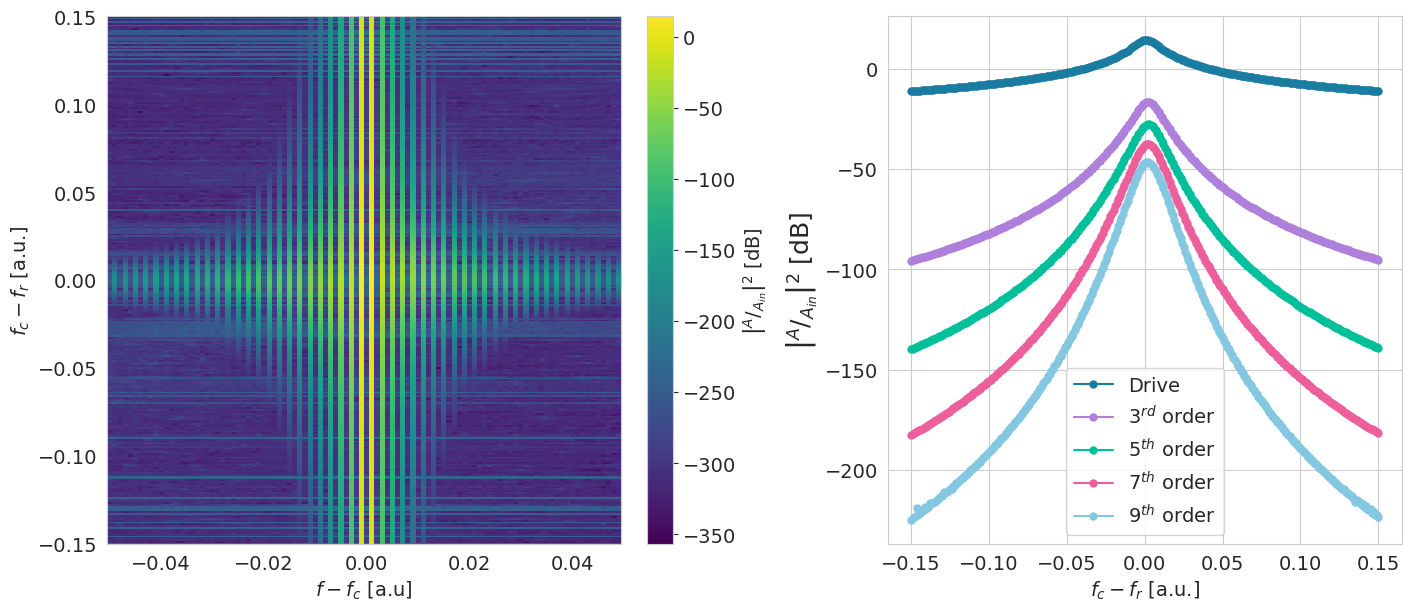

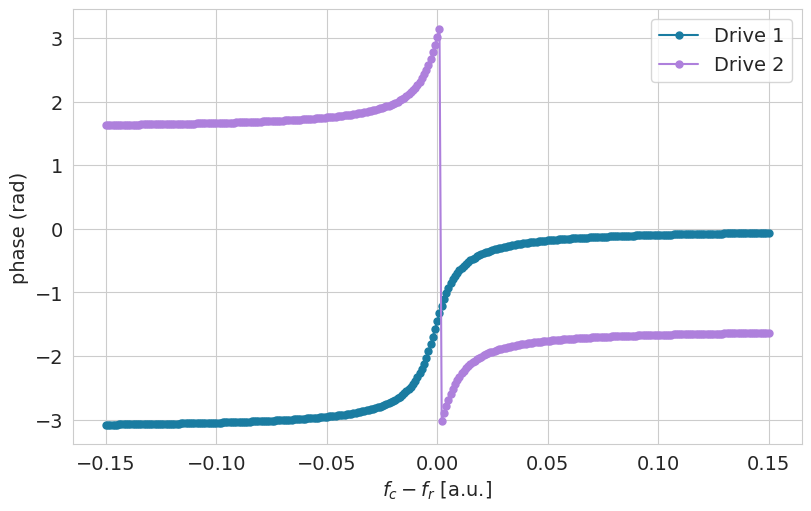

In [19]:
# 2D frequency sweep plot
f_lim = int(0.05 / df)

spectra, freqs = arrange_spectra(A_i_arr/F01, f, fs, df, f_lim, fd_arr)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

fig, ax, cmap = plot_2D_freq_sweep(spectra, freqs, fd_arr, fig, ax)

fig.colorbar(cmap, ax=ax[0], label=r'$ \left| ^{A}/_{A_{in}} \right|^2$ [dB]')
ax[1].set_ylabel(r'$ \left| ^{A}/_{A_{in}} \right|^2$ [dB]', fontsize=18)



# Phase calculation
# Rearrange the arrays so that negative frequencies correspond to [0:n/2] and positive to [n/2+1:]
A_i_phase = np.zeros_like(A_i_arr, dtype=float)
A_i_phase[:, :int(fs/df/2)] = np.angle(A_i_arr[:, int(fs/df/2):])
A_i_phase[:, int(fs/df/2)] = np.angle(A_i_arr[:, 0])
A_i_phase[:, int(fs/df/2)+1:] = np.angle(A_i_arr[:, 1:int(fs/df/2)])

# Arrays for plotting    
A_i_phase_plot = np.zeros_like(A_i_phase[:, :2*f_lim])
for fd_idx, fd_val in enumerate(fd_arr):
    index = int(np.round(fd_val / df, 1))
    A_i_phase_plot[fd_idx, :] = A_i_phase[fd_idx, int(fs/df/2)-f_lim-index:int(fs/df/2)+f_lim-index]


# phase plot
fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(fd_arr, A_i_phase_plot[:, int(len(freqs)/2-1)], 'o-',label="Drive 1", c='#1A7CA1', markersize=5)
ax.plot(fd_arr, A_i_phase_plot[:, int(len(freqs)/2+1)], 'o-',label="Drive 2", c='#AE80DC', markersize=5)
# ax.plot(fd_arr, A_i_phase_plot[:, int(len(freqs)/2+1+nstep)], 'o-', label=r"$3^{rd}$ order", c='#AE80DC', markersize=5)
# ax.plot(fd_arr, A_i_phase_plot[:, int(len(freqs)/2+1+2*nstep)], 'o-', label=r"$5^{th}$ order", c='#00BF9B', markersize=5)
# ax.plot(fd_arr, A_i_phase_plot[:, int(len(freqs)/2+1+3*nstep)], 'o-', label=r"$7^{th}$ order", c='#EC5F9B', markersize=5)

ax.set_xlabel('$f_c - f_r$ [a.u.]')
ax.set_ylabel('phase (rad)')
ax.legend()

plt.show()

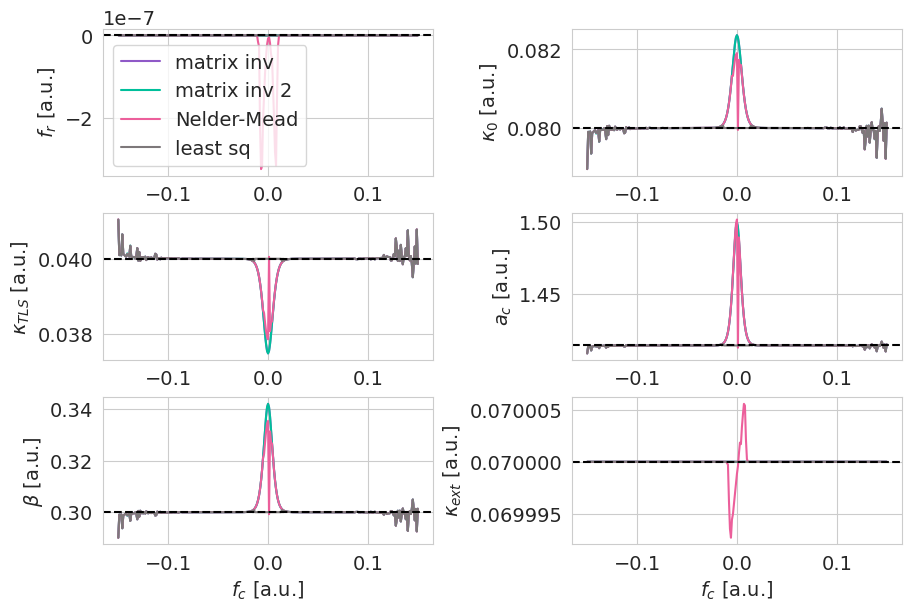

In [20]:
# Plot reconstructed parameters
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

ax[0, 0].plot(fd_arr, param_rec_hb_arr[:, 0], label='matrix inv')
ax[0, 0].plot(fd_arr, param_rec_hb_d_arr[:, 0], label='matrix inv 2')
ax[0, 0].plot(fd_arr, param_rec_sf_nm_arr[:, 0], label='Nelder-Mead')
ax[0, 0].plot(fd_arr, param_rec_sf_ls_arr[:, 0], label='least sq')
ax[0, 0].axhline(f0, ls='--', c='black')

ax[0, 1].plot(fd_arr, param_rec_hb_arr[:, 1])
ax[0, 1].plot(fd_arr, param_rec_hb_d_arr[:, 1])
ax[0, 1].plot(fd_arr, param_rec_sf_nm_arr[:, 1])
ax[0, 1].plot(fd_arr, param_rec_sf_ls_arr[:, 1])
ax[0, 1].axhline(k0, ls='--', c='black')

ax[1, 0].plot(fd_arr, param_rec_hb_arr[:, 2])
ax[1, 0].plot(fd_arr, param_rec_hb_d_arr[:, 2])
ax[1, 0].plot(fd_arr, param_rec_sf_nm_arr[:, 2])
ax[1, 0].plot(fd_arr, param_rec_sf_ls_arr[:, 2])
ax[1, 0].axhline(ktls, ls='--', c='black')

ax[1, 1].plot(fd_arr, param_rec_hb_arr[:, 3])
ax[1, 1].plot(fd_arr, param_rec_hb_d_arr[:, 3])
ax[1, 1].plot(fd_arr, param_rec_sf_nm_arr[:, 3])
ax[1, 1].plot(fd_arr, param_rec_sf_ls_arr[:, 3])
ax[1, 1].axhline(ac, ls='--', c='black')

ax[2, 0].plot(fd_arr, param_rec_hb_arr[:, 4])
ax[2, 0].plot(fd_arr, param_rec_hb_d_arr[:, 4])
ax[2, 0].plot(fd_arr, param_rec_sf_nm_arr[:, 4])
ax[2, 0].plot(fd_arr, param_rec_sf_ls_arr[:, 4])
ax[2, 0].axhline(beta, ls='--', c='black')

ax[2, 1].plot(fd_arr, param_rec_hb_arr[:, 5])
ax[2, 1].plot(fd_arr, param_rec_hb_d_arr[:, 5])
ax[2, 1].plot(fd_arr, param_rec_sf_nm_arr[:, 5])
ax[2, 1].plot(fd_arr, param_rec_sf_ls_arr[:, 5])
ax[2, 1].axhline(kext, ls='--', c='black')

# labels
ax[2, 0].set_xlabel('$f_c$ [a.u.]')
ax[2, 1].set_xlabel('$f_c$ [a.u.]')
ax[0, 0].set_ylabel('$f_r$ [a.u.]')
ax[1, 0].set_ylabel('$\kappa_{TLS}$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$a_c$ [a.u.]')
ax[2, 0].set_ylabel(r'$\beta$ [a.u.]')
ax[2, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')
ax[0, 0].legend()

plt.show()

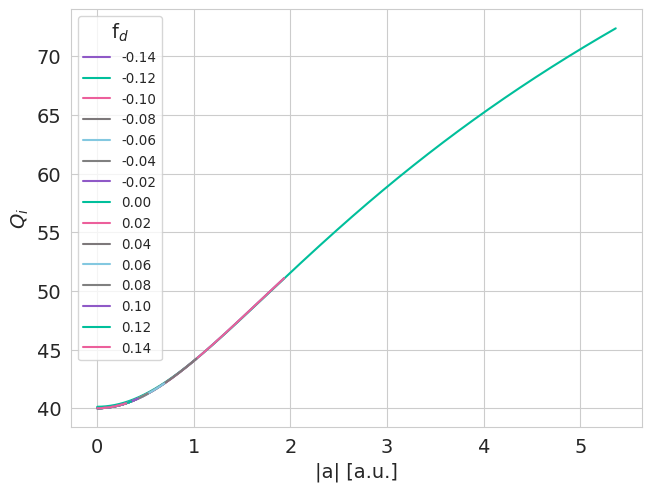

In [21]:
# plot Q factor vs photon number as we sweep the frequency
fig, ax = plt.subplots(1)
for freq_idx, freq_val in enumerate(fd_arr[10::20]):
    idx = 10 + 20 * freq_idx
    xsim = np.linspace(0, xmax_arr[idx], 1000)
    Q_int = 1 / (tls_function(xsim, *param_rec_hb_arr[idx, 1:-1]) - param_rec_hb_arr[idx, -1] / 2)
    ax.plot(xsim, Q_int, label=f'{freq_val:.2f}')

ax.set_xlabel('|a| [a.u.]')
ax.set_ylabel(r'$Q_i$')
ax.legend(loc='upper left', title='f$_d$', fontsize='x-small')
plt.show()

#### Drive power sweep

We now sweep the drive strength $F_0$, and again reconstruct the system using the harmonic balance technique to recover the parameters of the system as a function of the pump strengths.

In [22]:
# drive parameters
F01_arr = np.logspace(-2, 2, 200)  # drive 1 amplitude


nimps = 100
nstep = int((fd2 - fd1) / df)
imps_ind = np.arange(drives_ind[1] - nimps*nstep, drives_ind[0] + nimps*nstep + nstep, nstep)

# Empty arrays
kext_rec_ii = np.zeros_like(F01_arr)
f0_rec_ii = np.zeros_like(F01_arr)
k0_rec_ii = np.zeros_like(F01_arr)
ktls_rec_ii = np.zeros_like(F01_arr)
ac_rec_ii = np.zeros_like(F01_arr)
beta_rec_ii = np.zeros_like(F01_arr)

kext_rec_d_ii = np.zeros_like(F01_arr)
f0_rec_d_ii = np.zeros_like(F01_arr)
k0_rec_d_ii = np.zeros_like(F01_arr)
ktls_rec_d_ii = np.zeros_like(F01_arr)
ac_rec_d_ii = np.zeros_like(F01_arr)
beta_rec_d_ii = np.zeros_like(F01_arr)

A_ii_arr = np.zeros((len(F01_arr), int(fs/df)), dtype=complex)
a_ii_arr = np.zeros_like(A_ii_arr)
ain_ii_arr = np.zeros_like(A_ii_arr)
Ain_ii_arr = np.zeros_like(A_ii_arr)

param_ii_rec_hb_arr = np.zeros((len(F01_arr), len(param_rec_hb)))
param_ii_rec_hb_d_arr = np.zeros_like(param_ii_rec_hb_arr)
param_ii_rec_sf_nm_arr = np.zeros_like(param_ii_rec_hb_arr)
param_ii_rec_sf_ls_arr = np.zeros_like(param_ii_rec_hb_arr)

xmax_ii_arr = np.zeros_like(F01_arr)

# Simulation
with tqdm(total=len(F01_arr), ncols=80) as pbar:
    for F0_idx, F0_val in enumerate(F01_arr):

        # run the integrator
        A_ii_arr[F0_idx], a_ii_arr[F0_idx], f, t = hb.tls_simulation(time_=time,
                                                                     f0_=f0,
                                                                     k0_=k0,
                                                                     ktls_=ktls,
                                                                     ac_=ac,
                                                                     beta_=beta,
                                                                     F1_=F0_val,
                                                                     F2_=F0_val,
                                                                     fd1_=fd1,
                                                                     fd2_=fd2,
                                                                     kext_=kext,
                                                                     psi_=psi,
                                                                     y0_=y0,
                                                                     N_=N,
                                                                     dt_=dt,
                                                                     )
        
        # input field
        ain_ii_arr[F0_idx] = F0_val * (np.exp(-1j * 2 * np.pi * fd1 * t) + np.exp(-1j * (2 * np.pi * fd2 * t + psi)))
        Ain_ii_arr[F0_idx] = np.fft.fft(ain_ii_arr[F0_idx]) / len(ain_ii_arr[F0_idx])

        # Reconstuction
        kext_rec_ii[F0_idx], f0_rec_ii[F0_idx], d_rec, _ = hb.tls_reconstruction(A_ii_arr[F0_idx], 
                                                                                 Ain_ii_arr[F0_idx],
                                                                                 a_ii_arr[F0_idx], 
                                                                                 ain_ii_arr[F0_idx],
                                                                                 f, 
                                                                                 imps_ind,
                                                                                 n,
                                                                                 )
        
        kext_rec_d_ii[F0_idx], f0_rec_d_ii[F0_idx], d_rec_d, _ = hb.tls_reconstruction(A_ii_arr[F0_idx], 
                                                                                       Ain_ii_arr[F0_idx],
                                                                                       a_ii_arr[F0_idx], 
                                                                                       ain_ii_arr[F0_idx],
                                                                                       f, 
                                                                                       imps_ind,
                                                                                       n,
                                                                                       daniel=True,
                                                                                       )

        # Reconstructed damping using complex time-domain spectra
        xmax = np.max(np.abs(a_ii_arr[F0_idx]))
        xmax_ii_arr[F0_idx] = xmax
        x_sim = np.linspace(0, xmax, 10000)
        y_rec = 0
        for coef_ind, coef_val in enumerate(d_rec):
            y_rec += coef_val * x_sim**(2 * coef_ind)
        y_rec_d = 0
        for coef_ind, coef_val in enumerate(d_rec_d):
            y_rec_d += coef_val * x_sim**(2 * coef_ind)

        # curve fit of the reconstructed damping to get the tls parameters
        popt = curve_fit(tls_function, x_sim, y_rec,
                         p0=[k0, ktls, ac, beta], maxfev=10_000)
        
        k0_rec_ii[F0_idx] = popt[0][0]
        ktls_rec_ii[F0_idx] = popt[0][1]
        ac_rec_ii[F0_idx] = popt[0][2]
        beta_rec_ii[F0_idx] = popt[0][3]
        
        param_ii_rec_hb_arr[F0_idx] = f0_rec_ii[F0_idx], k0_rec_ii[F0_idx], ktls_rec_ii[F0_idx], ac_rec_ii[F0_idx], beta_rec_ii[F0_idx], kext_rec_ii[F0_idx]
        
        # curve fit of the reconstructed damping to get the tls parameters
        popt = curve_fit(tls_function, x_sim, y_rec_d,
                         p0=[k0, ktls, ac, beta], maxfev=10_000)
        
        k0_rec_d_ii[F0_idx] = popt[0][0]
        ktls_rec_d_ii[F0_idx] = popt[0][1]
        ac_rec_d_ii[F0_idx] = popt[0][2]
        beta_rec_d_ii[F0_idx] = popt[0][3]
        
        param_ii_rec_hb_d_arr[F0_idx] = f0_rec_d_ii[F0_idx], k0_rec_d_ii[F0_idx], ktls_rec_d_ii[F0_idx], ac_rec_d_ii[F0_idx], beta_rec_d_ii[F0_idx], kext_rec_d_ii[F0_idx]
        
                    
        # Spectrum fitting reconstruction
        Apartial = A_ii_arr[F0_idx, imps_ind]

        Apartial_zp = np.zeros(len(A_ii_arr[F0_idx]), dtype=complex)
        Apartial_zp[imps_ind] = Apartial
        apartial = np.fft.ifft(Apartial_zp)
        apartial *= len(apartial)

        Ain_partial = Ain_ii_arr[F0_idx, imps_ind]

        # Initial guess
        x0 = param_ii_rec_hb_arr[F0_idx]

        # Nelder-Mead algorithm
        res = scipy.optimize.minimize(error_func_nm, (x0), tol=1e-10)
        param_ii_rec_sf_nm_arr[F0_idx] = res.x

        # least squares algorithm
        res = scipy.optimize.least_squares(error_func_ls, x0)
        param_ii_rec_sf_ls_arr[F0_idx] = res.x

        pbar.update(1)

100%|█████████████████████████████████████████| 200/200 [03:36<00:00,  1.08s/it]


In [23]:
# Plot: steady-state fields in the time and frequency domain

def plot_power_sweep(F0_ind):
    
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.abs(a_ii_arr[F0_ind]))
    ax[0].plot(t, np.abs(ain_ii_arr[F0_ind]))
    ax[1].semilogy(f, np.abs(A_ii_arr[F0_ind])**2, label=r'$A_{out}$')
    ax[1].semilogy(f, np.abs(Ain_ii_arr[F0_ind])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[imps_ind], np.abs(A_ii_arr[F0_ind])[imps_ind]**2, '.', label=r'$A_{IMP}$')

    # labels
    ax[0].set_title(r'$F_0$' + f' = {F01_arr[F0_ind]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A|^2$ [a.u.]')
    ax[1].set_xlim([-df*200, df*200])
    ax[1].set_ylim([np.min(np.abs(A_ii_arr)**2)/10, np.max(np.abs(A_ii_arr)**2)*10])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_power_sweep,
                 F0_ind=widgets.IntSlider(min=0,
                                          max=len(F01_arr)-1,
                                          step=1,
                                          description='F0 ind',
                                         )
                )


plt.show()

interactive(children=(IntSlider(value=0, description='F0 ind', max=199), Output()), _dom_classes=('widget-inte…

In [24]:
def plot_power_dependence(A_, P_, fs_, df_, drives_ind_, nstep_, cutoff_):
    
    # Slope of the linear regime
    slope_3 = np.log10(np.abs(A_[-1, drives_ind_[1]-nstep_])**2 / np.abs(A_[cutoff_, drives_ind_[1]-nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_5 = np.log10(np.abs(A_[-1, drives_ind_[1]-2*nstep_])**2 / np.abs(A_[cutoff_, drives_ind_[1]-2*nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_7 = np.log10(np.abs(A_[-1, drives_ind_[1]-3*nstep_])**2 / np.abs(A_[cutoff_, drives_ind_[1]-3*nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_9 = np.log10(np.abs(A_[-1, drives_ind_[1]-4*nstep_])**2 / np.abs(A_[cutoff_, drives_ind_[1]-4*nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])

    n_3 = np.log10(np.abs(A_[-1, drives_ind_[1]-nstep_])**2 / P_[-1]**(slope_3))
    n_5 = np.log10(np.abs(A_[-1, drives_ind_[1]-2*nstep_])**2 / P_[-1]**(slope_5))
    n_7 = np.log10(np.abs(A_[-1, drives_ind_[1]-3*nstep_])**2 / P_[-1]**(slope_7))
    n_9 = np.log10(np.abs(A_[-1, drives_ind_[1]-4*nstep_])**2 / P_[-1]**(slope_9))
    
    print(slope_3, slope_5, slope_7, slope_9)
    print(n_3, n_5, n_7, n_9)
    
    # Plot power dependence
    # ax.loglog(P_, np.abs(A_[:, drives_ind_[0]])**2, 'o-',label="Drive", c='#1A7CA1', markersize=5)
    ax.loglog(P_, np.abs(A_[:, drives_ind_[1]-nstep_])**2, 'o-', label=r"$3^{rd}$ order", c='#AE80DC', markersize=5)
    ax.loglog(P_, 10**(slope_3*np.log10(P_) + n_3), ls='--', c='#AE80DC')
    ax.loglog(P_, np.abs(A_[:, drives_ind_[1]-2*nstep_])**2, 'o-', label=r"$5^{th}$ order", c='#00BF9B', markersize=5)
    ax.loglog(P_, 10**(slope_5*np.log10(P_) + n_5), ls='--', c='#00BF9B')
    ax.loglog(P_, np.abs(A_[:, drives_ind_[1]-3*nstep_])**2, 'o-', label=r"$7^{th}$ order", c='#EC5F9B', markersize=5)
    ax.loglog(P_, 10**(slope_7*np.log10(P_) + n_7), ls='--', c='#EC5F9B')
    ax.loglog(P_, np.abs(A_[:, drives_ind_[1]-4*nstep_])**2, 'o-', label=r"$9^{th}$ order", c='#83C8E0', markersize=5)
    ax.loglog(P_, 10**(slope_9*np.log10(P_) + n_9), ls='--', c='#83C8E0')
    
    if verbose:
        ax.axvline(P_[cutoff], ls='--', c='black')
        
    return fig, ax

0.4163824268668016 0.42199262775149493 0.4269105683545607 0.4320385544287355
-1.858600925895458 -2.6370279378304224 -3.2041318568763275 -3.6631098736640344


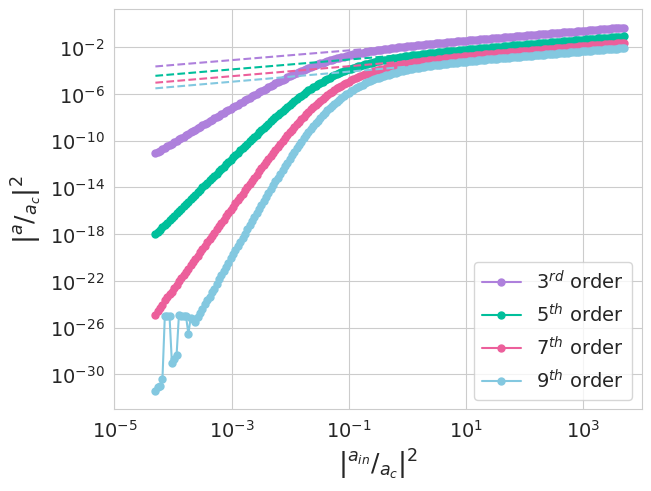

In [25]:
verbose = False

# Linear fits
cutoff = 132

# Plot drive power dependence
fig, ax = plt.subplots(1)

fig, ax = plot_power_dependence(A_ii_arr/ac, F01_arr**2/ac**2, fs, df, drives_ind, nstep, cutoff)

ax.set_ylabel(r'$\left| ^{a}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlabel(r'$\left| ^{a_{in}}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlim(1e-5, 1e4)
ax.legend(loc='lower right')

plt.show()

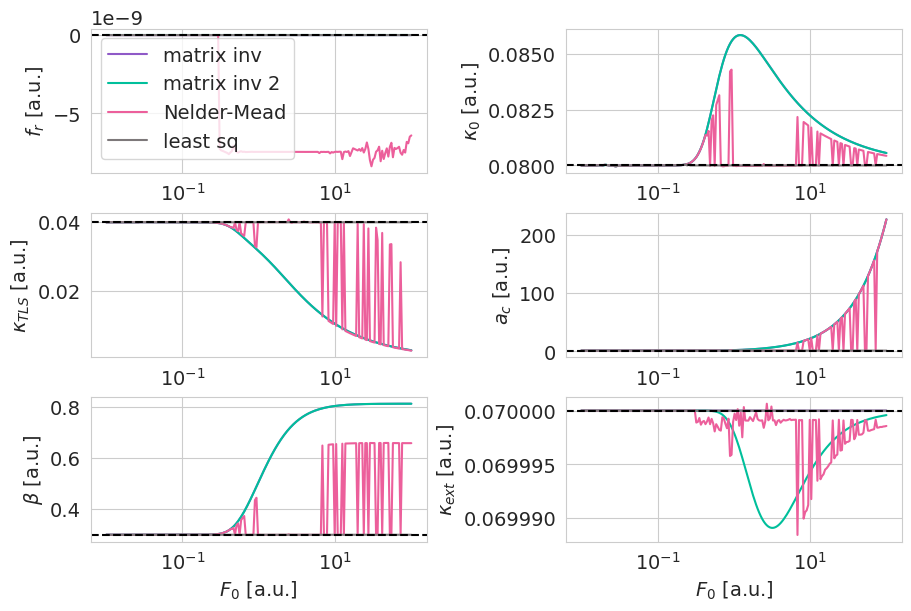

In [26]:
# Plot reconstructed parameters
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

ax[0, 0].semilogx(F01_arr, param_ii_rec_hb_arr[:, 0], label='matrix inv')
ax[0, 0].semilogx(F01_arr, param_ii_rec_hb_d_arr[:, 0], label='matrix inv 2')
ax[0, 0].semilogx(F01_arr, param_ii_rec_sf_nm_arr[:, 0], label='Nelder-Mead')
ax[0, 0].semilogx(F01_arr, param_ii_rec_sf_ls_arr[:, 0], label='least sq')
ax[0, 0].axhline(f0, ls='--', c='black')

ax[0, 1].semilogx(F01_arr, param_ii_rec_hb_arr[:, 1])
ax[0, 1].semilogx(F01_arr, param_ii_rec_hb_d_arr[:, 1])
ax[0, 1].semilogx(F01_arr, param_ii_rec_sf_nm_arr[:, 1])
ax[0, 1].semilogx(F01_arr, param_ii_rec_sf_ls_arr[:, 1])
ax[0, 1].axhline(k0, ls='--', c='black')

ax[1, 0].semilogx(F01_arr, param_ii_rec_hb_arr[:, 2])
ax[1, 0].semilogx(F01_arr, param_ii_rec_hb_d_arr[:, 2])
ax[1, 0].semilogx(F01_arr, param_ii_rec_sf_nm_arr[:, 2])
ax[1, 0].semilogx(F01_arr, param_ii_rec_sf_ls_arr[:, 2])
ax[1, 0].axhline(ktls, ls='--', c='black')

ax[1, 1].semilogx(F01_arr, param_ii_rec_hb_arr[:, 3])
ax[1, 1].semilogx(F01_arr, param_ii_rec_hb_d_arr[:, 3])
ax[1, 1].semilogx(F01_arr, param_ii_rec_sf_nm_arr[:, 3])
ax[1, 1].semilogx(F01_arr, param_ii_rec_sf_ls_arr[:, 3])
ax[1, 1].axhline(ac, ls='--', c='black')

ax[2, 0].semilogx(F01_arr, param_ii_rec_hb_arr[:, 4])
ax[2, 0].semilogx(F01_arr, param_ii_rec_hb_d_arr[:, 4])
ax[2, 0].semilogx(F01_arr, param_ii_rec_sf_nm_arr[:, 4])
ax[2, 0].semilogx(F01_arr, param_ii_rec_sf_ls_arr[:, 4])
ax[2, 0].axhline(beta, ls='--', c='black')

ax[2, 1].semilogx(F01_arr, param_ii_rec_hb_arr[:, 5])
ax[2, 1].semilogx(F01_arr, param_ii_rec_hb_d_arr[:, 5])
ax[2, 1].semilogx(F01_arr, param_ii_rec_sf_nm_arr[:, 5])
ax[2, 1].semilogx(F01_arr, param_ii_rec_sf_ls_arr[:, 5])
ax[2, 1].axhline(kext, ls='--', c='black')

# labels
ax[2, 0].set_xlabel('$F_0$ [a.u.]')
ax[2, 1].set_xlabel('$F_0$ [a.u.]')
ax[0, 0].set_ylabel('$f_r$ [a.u.]')
ax[1, 0].set_ylabel('$\kappa_{TLS}$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$a_c$ [a.u.]')
ax[2, 0].set_ylabel(r'$\beta$ [a.u.]')
ax[2, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')
ax[0, 0].legend()

plt.show()

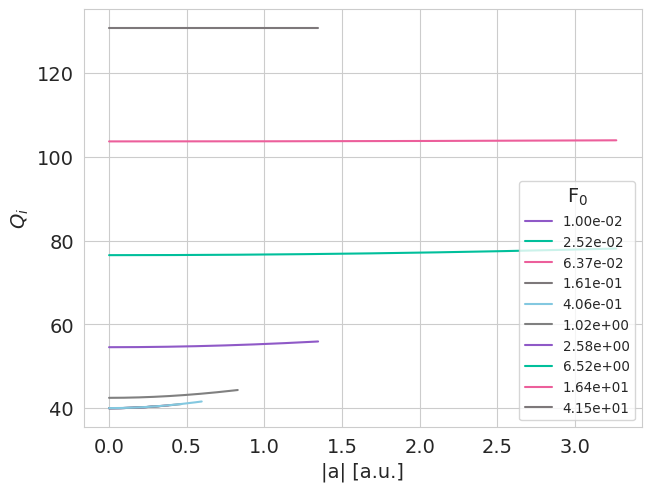

In [27]:
# plot Q factor vs photon number as we sweep the frequency
fig, ax = plt.subplots(1)
for F_idx, F_val in enumerate(F01_arr[::20]):
    idx = 20 * F_idx
    xsim = np.linspace(0, xmax_arr[idx], 1000)
    Q_int = 1 / (tls_function(xsim, *param_ii_rec_hb_arr[idx, 1:-1]) - param_ii_rec_hb_arr[idx, -1] / 2)
    ax.plot(xsim, Q_int, label=f'{F_val:.2e}')

ax.set_xlabel('|a| [a.u.]')
ax.set_ylabel(r'$Q_i$')
ax.legend(loc='lower right', title='F$_0$', fontsize='x-small')
plt.show()

## Input-output theory

Let us consider now the case where we have our resonator capacitively coupled to a transmission line in a notch configuration.
The intra-cavity field is given by the following input-output relation:

$$ e^{i \alpha}\dfrac{a_{out}}{\sqrt{\mathcal{G}}} = \sqrt{\kappa_0^{ext}} a + e^{i\delta}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \quad \rightarrow \quad a = \dfrac{1}{\sqrt{\kappa_0^{ext}}} e^{i \alpha} \left( \dfrac{a_{out}}{\sqrt{\mathcal{G}}} - e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right), $$

where $\mathcal{G}$ and $\mathcal{A}$ are the gain and attenuation of the output and input line respectively, $\kappa_0^{ext} \in \mathbb{C}$ represents the waveguide-resonator coupling rate, and $\phi$ simbolizes the phase delay between the input and output lines.

To calculate the output field, we need the phase delay $\phi$, and the gain $\mathcal{G}$ and attenuation $\mathcal{A}$ of our input and output lines.
To obtain these parameters, we use an out-of-resonance measurement.

#### Out-of-resonance measurement

Typically, the phase delay $\phi$ and the attenuation $\mathcal{A}$ are parameters not easy to obtain experimentally.
Therefore, to obtain the phase delay $\phi$ between the input and output fields, we analyze the system out of resonance.

The input-output relation out of resonance is given by

$$ \dfrac{a_{out}}{\sqrt{\mathcal{G}}} = e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}}. $$

In the frequency domain:

$$ \dfrac{A_{out,k}}{\sqrt{\mathcal{G}}} = e^{i\phi} \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \quad \rightarrow \quad e^{i\phi}\sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} = \dfrac{A_{out,k}}{A_{in,k}} $$

Thus we solve the equation of motion for the output and input fields, which is given by:

$$ \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{a}_{in} = -i \omega_0 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \dfrac{\kappa_0}{2} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \dfrac{\kappa_{TLS}/2}{\left[ {1 + \left( \dfrac{ \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|}{\sqrt{\mathcal{G}} \sqrt{\kappa_0^{ext}} a_c} \right)^2} \right]^\beta} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \kappa_0^{ext} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}$$

In [28]:
# drive parameters
fd1_off = 5.99  # drive 1 frequency
fd2_off = 6.01  # drive 2 frequency


# run the integrator
Aout_off, aout_off, _, _ = hb.tls_simulation(time_=time,
                                             f0_=f0,
                                             k0_=k0,
                                             ktls_=ktls,
                                             ac_=ac,
                                             beta_=beta,
                                             F1_=F01,
                                             F2_=F02,
                                             fd1_=fd1_off,
                                             fd2_=fd2_off,
                                             kext_=kext,
                                             psi_=psi,
                                             phase_=phase_delay,
                                             gain_=gain,
                                             att_=att,
                                             y0_=y0,
                                             N_=N,
                                             dt_=dt,
                                             in_out=True
                                             )


# Input field 
ain_off = F01 * np.exp(-1j * 2 * np.pi * fd1_off * t) + F02 * np.exp(-1j * (2 * np.pi * fd2_off * t + psi))
Ain_off = np.fft.fft(ain_off) / len(ain_off)

# IMPs
drives_ind_off = -np.array([int(round(fd1_off / df, 1)), int(round(fd2_off / df, 1))])

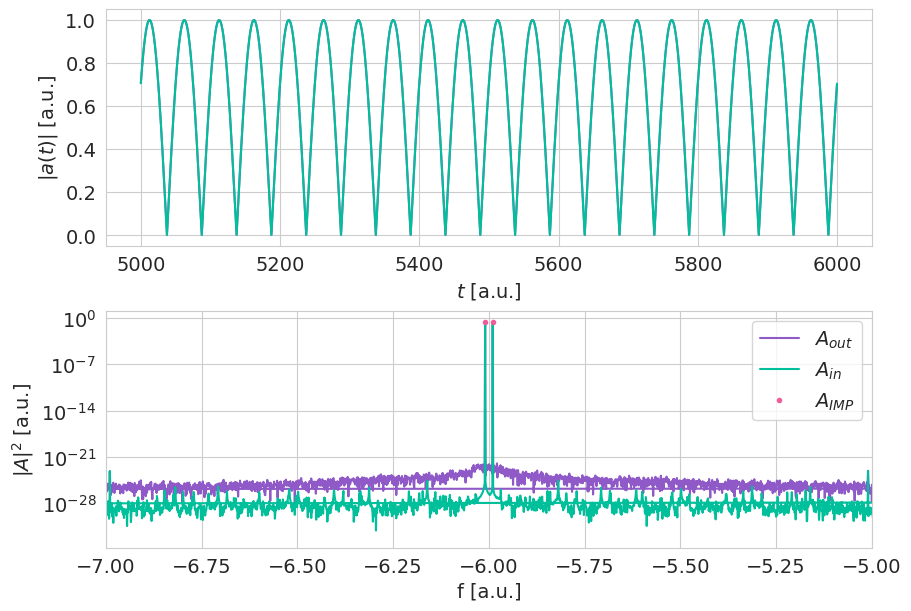

In [29]:
# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.abs(aout_off))
ax[0].plot(t, np.abs(ain_off))
ax[1].semilogy(f, np.abs(Aout_off)**2, label=r'$A_{out}$')
ax[1].semilogy(f, np.abs(Ain_off)**2, label=r'$A_{in}$')
ax[1].semilogy(f[drives_ind_off], np.abs(Ain_off[drives_ind_off])**2, '.', label=r'$A_{IMP}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$|a(t)|$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-7, -5])
ax[1].legend()

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-off_res.png', dpi=300)

We then recover the phase delay and the gain and attenuation ratio.

In [30]:
# Reconstructed phase
phase_factor_rec = Aout_off[drives_ind_off[0]] / Ain_off[drives_ind_off[0]]

print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter','Simulation','Reconstruction') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format(r'√(G/A)', f'{np.sqrt(gain / att):.5f}', f'{np.abs(phase_factor_rec):.6f}'))
print('{:<15} {:<15} {:<15}'.format(r'φ', f'{phase_delay:.5f}', f'{np.angle(phase_factor_rec):.6f}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction 
√(G/A)          1.00000         0.999999       
φ               0.00000         -0.001860      


We then reconstruct the output field for the on-resonance measurement, and plot it together with the intra-cavity and input fields.

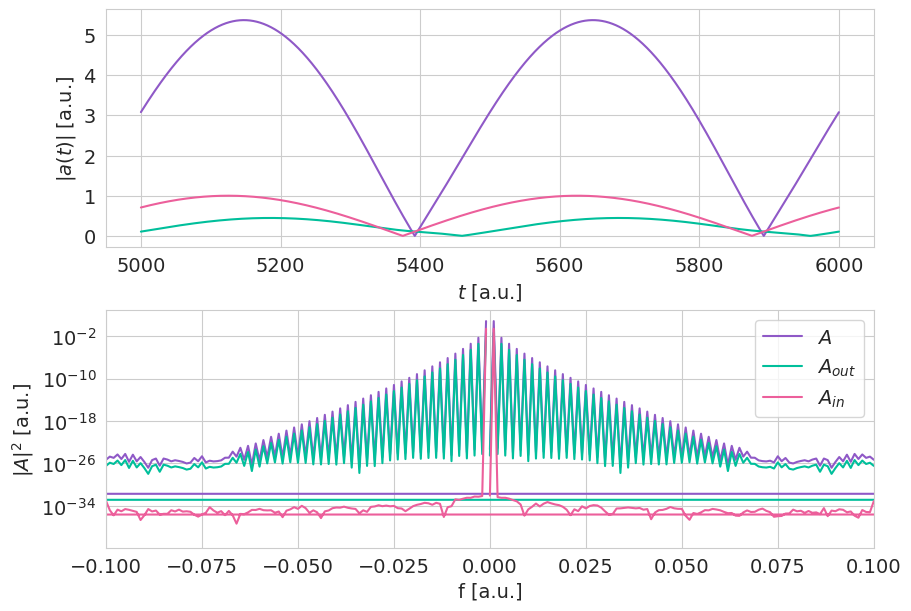

In [31]:
# We assume the gain known, and calculate the attenuation as:
att_rec = gain / np.abs(phase_factor_rec)**2
phase_delay_rec = np.angle(phase_factor_rec)

# output field
aout = np.sqrt(gain) * np.exp(1.0j * alpha) * (np.sqrt(kext_rec) * a_rec + 
                                               np.exp(1.0j * phase_delay_rec) * ain / np.sqrt(att_rec))
Aout = np.fft.fft(aout) / len(aout)


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.abs(a_rec))
ax[0].plot(t, np.abs(aout))
ax[0].plot(t, np.abs(ain))
ax[1].semilogy(f, np.abs(A_rec)**2, label=r'$A$')
ax[1].semilogy(f, np.abs(Aout)**2, label=r'$A_{out}$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$|a(t)|$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

As a sanity check, we solve the equation of motion for the output field, and compare the result to the field we obtained using the input-output relation.

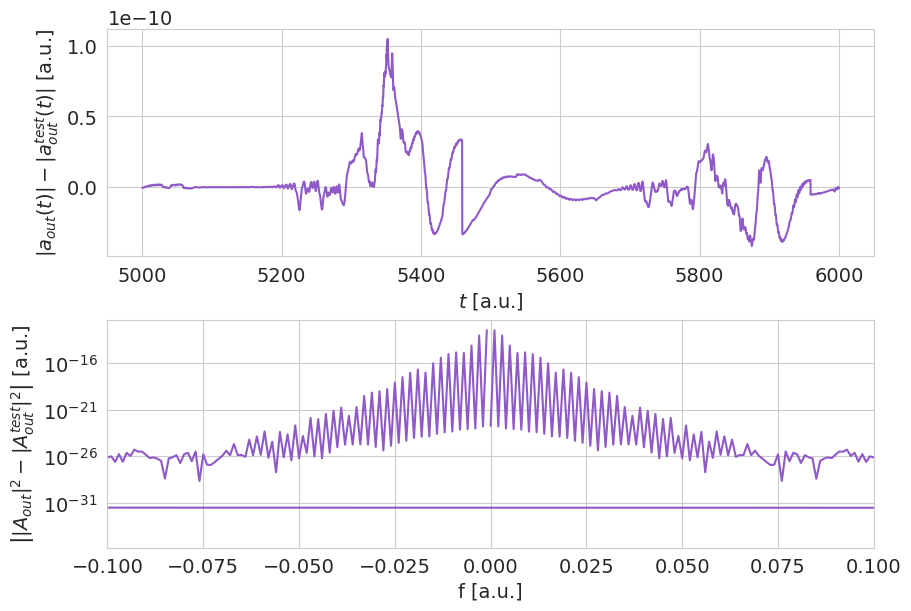

In [32]:
verbose = False

# Output field solving the eom for the intra cavity field and then applying the in-out relation
aout_1 = np.sqrt(gain) * np.exp(1.0j * alpha) * (np.sqrt(kext) * a + 
                                                 np.exp(1.0j * phase_delay) * ain / np.sqrt(att))
Aout_1 = np.fft.fft(aout_1) / len(aout_1)

# Output field solving the eom for the output field
Aout_2, aout_2, f, t = hb.tls_simulation(time_=time,
                                         f0_=f0,
                                         k0_=k0,
                                         ktls_=ktls,
                                         ac_=ac,
                                         beta_=beta,
                                         F1_=F01,
                                         F2_=F02,
                                         fd1_=fd1,
                                         fd2_=fd2,
                                         kext_=kext,
                                         psi_=psi,
                                         phase_=phase_delay,
                                         gain_=gain,
                                         att_=att,
                                         y0_=y0,
                                         N_=N,
                                         dt_=dt,
                                         in_out=True
                                         )

if verbose:
    print(np.max(np.abs(np.abs(Aout_1)**2 - np.abs(Aout_2)**2)))
    print(np.max(np.abs(Aout_1)**2))


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.abs(aout_1) - np.abs(aout_2))
ax[1].semilogy(f, np.abs(np.abs(Aout_1)**2 - np.abs(Aout_2)**2))
# ax[1].semilogy(f, np.abs(Aout_1)**2)
# ax[1].semilogy(f, np.abs(Aout_2)**2)

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$|a_{out}(t)| - |a_{out}^{test}(t)|$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel(r'$\left| |A_{out}|^2 - |A_{out}^{test}|^2 \right| $ [a.u.]')
ax[1].set_xlim([-df*100, df*100])

plt.show()

## Output field simulations

In our experiment, we measure the output field and have no information about the intra-cavity field.
We now want to see if we are able to reconstruct the non-linear system applying harmonic balance directly on the output field.

To do so, we start simulating the output field using the input-output relation stated before and the equation of motion for the intra-cavity field.
The equation of motion for the output field reads:

$$ \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{a}_{in} = -i \omega_0 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \dfrac{\kappa_0}{2} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \dfrac{\kappa_{TLS}/2}{\left[ {1 + \left( \dfrac{ \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|}{\sqrt{\mathcal{G}} \sqrt{\kappa_0^{ext}} a_c} \right)^2} \right]^\beta} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \kappa_0^{ext} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}$$

Thus we expand the $\beta$ denominator obtaining:

$$ \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{a}_{in} = -i \omega_0 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \left( \dfrac{\kappa_0}{2} + c_1 \right) \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - c_3 \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - c_5 \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^4 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \cdot \cdot \cdot - c_n \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^{n-1} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \kappa_0^{ext} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}$$

We solve numerically the equation of motion obtaining the following spectrum:

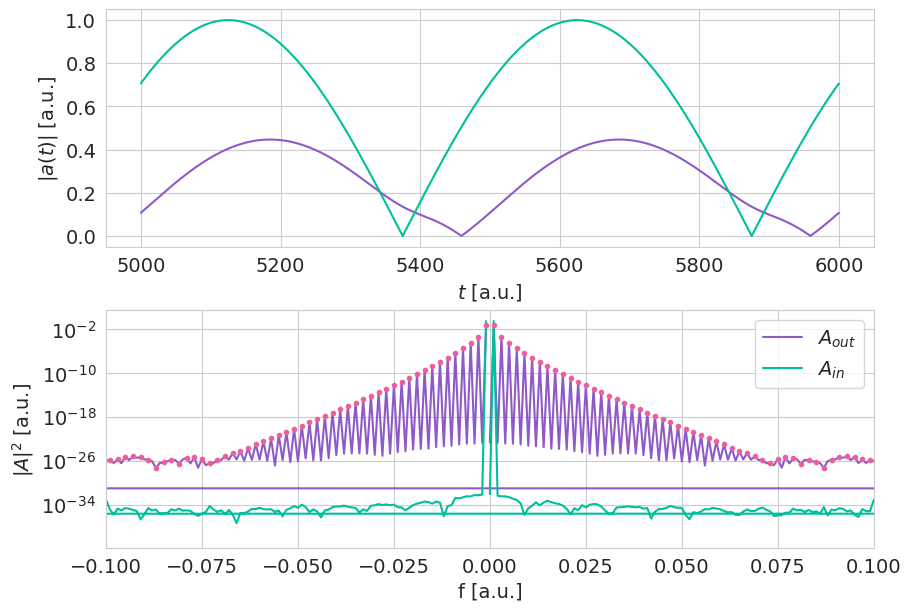

In [33]:
# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.abs(aout_2))
ax[0].plot(t, np.abs(ain))
ax[1].semilogy(f, np.abs(Aout_2)**2, label=r'$A_{out}$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')
ax[1].semilogy(f[imps_ind], np.abs(Aout_2[imps_ind])**2, '.')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$|a(t)|$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim.png', dpi=300)

### Harmonic balance reconstruction by pseudomatrix inversion

We now write the eom in a matrix form, obtaining:

$$ \begin{pmatrix} \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{a}_{in} & i \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) & a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} & \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) & \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^4 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) & \cdot \cdot \cdot & \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^{n-1} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) \end{pmatrix} 
\begin{pmatrix} 1 / \kappa_0^{ext} \\ \omega_0 / \kappa_0^{ext} \\ c_1' / \kappa_0^{ext} \\ c_3 / \kappa_0^{ext} \\ \vdots \\ c_n / \kappa_0^{ext}  \end{pmatrix} = - e^{i\phi}\sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}$$

Transforming the eom to the Fourier domain, we obtain:

$$ \begin{pmatrix} i \omega_k \left( \dot{A}_{out, k} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{A}_{in, k} \right) & i \left( A_{out, k} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} A_{in, k} \right) & A_{out, k} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} A_{in, k} &  \mathscr{F}\left\{ \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) \right\}_k & \cdot \cdot \cdot & \mathscr{F}\left\{ \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^{n-1} \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) \right\}_k \end{pmatrix} 
\begin{pmatrix} -1/\kappa_0^{ext} \\ -\omega_0/\kappa_0^{ext} \\ -c_1'/\kappa_0^{ext} \\ -c_3/\kappa_0^{ext} \\ \vdots \\ -c_n/\kappa_0^{ext} \end{pmatrix} = e^{i\phi}\sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} A_{in, k}$$

In this way, we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain the least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

Similarly as before, we simulate the damping to see how many terms in the expansion we need:

In [34]:
# TLS damping function
def tls_function_2(x, κ0_, κtls_, ac_, beta_, kext_, gain_):
    return κ0_ / 2 + κtls_ / 2 / (1 + (np.abs(x) / (np.sqrt(gain_ * kext_) * ac_))**2)**beta_


def error_func_nm_2(w):
    
    if constrained:
        ktls_, ac_, kext_ = w
        f0_ = f0
        k0_ = k0
        beta_ = beta
        
    else:
        f0_, k0_, ktls_, ac_, kext_, beta_ = w
    
    epsilon = (1.0j * 2 * np.pi * (f[imps_ind] + f0_) * Apartial + 
               k0_ / 2 * Apartial + 
               ktls_ / 2 * np.fft.fft(1 / (1 + (np.abs(apartial) / (np.sqrt(kext_) * ac_)) ** 2) ** beta_ * apartial)[imps_ind] / len(apartial) +
               kext_ * Ain_partial
              )
        
    return(np.sum(np.real(epsilon)**2 + np.imag(epsilon)**2))


def error_func_ls_2(w):
    
    if constrained:
        ktls_, ac_, kext_ = w
        f0_ = f0
        k0_ = k0
        beta_ = beta
        
    else:
        f0_, k0_, ktls_, ac_, kext_, beta_ = w
        
    epsilon = (1.0j * 2 * np.pi * (f[imps_ind] + f0_) * Apartial + 
               k0_ / 2 * Apartial + 
               ktls_ / 2 * np.fft.fft(1 / (1 + (np.abs(apartial) / (np.sqrt(kext_) * ac_)) ** 2) ** beta_ * apartial)[imps_ind] / len(apartial) +
               kext_ * Ain_partial
              )
        
    return(np.concatenate((np.real(epsilon), np.imag(epsilon))))

FIT PARAMETERS
c1 = 5.998e-02
c3 = -4.030e-02
c5 = 1.352e-01
c7 = -3.483e-01
c9 = 5.999e-01
c11 = -6.690e-01
c13 = 4.743e-01
c15 = -2.057e-01
c17 = 4.963e-02
c19 = -5.099e-03


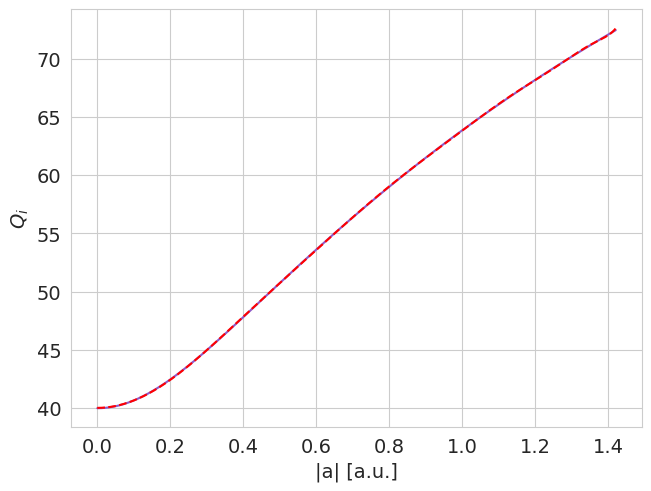

In [35]:
# We simulate the TLS non-linearity (do it in time domain!)
xmax = np.max(np.abs(aout_2 - phase_factor_rec * ain))
x_sim = np.linspace(0, xmax, 10000)
y_sim = tls_function_2(x_sim, k0, ktls, ac, beta, kext, gain)

# Polynomial fit up to nth order
n = np.arange(0, 19, 2)
coefficients = np.polynomial.polynomial.polyfit(x_sim, y_sim, n)

# Fit data
y_fit = 0
print('\033[1m' + 'FIT PARAMETERS' + '\033[0m')
for coef_ind, coef_val in enumerate(coefficients):
    y_fit += coef_val * x_sim ** coef_ind
    if coef_ind%2 == 0:
        print(f'c{coef_ind+1} = {coef_val:.3e}')

# Plot
fig7, ax7 = plt.subplots(1)
ax7.plot(x_sim, 1 / (y_sim - kext/2))
ax7.plot(x_sim, 1 / (y_fit - kext/2), 'r--')
ax7.set_xlabel('|a| [a.u.]')
ax7.set_ylabel('$Q_i$')

plt.show()

In [36]:
phase_factor_sim = np.sqrt(gain / att) * np.exp(1.0j * phase_delay)

# Reconstruction using the complex time-domain spectra
kext_rec, f0_rec, d_rec, Q_fit = hb.tls_reconstruction(Field=Aout_2,
                                                       Field_in=phase_factor_rec * Ain,
                                                       field=aout_2,
                                                       field_in=phase_factor_rec * ain,
                                                       freqs=f,
                                                       indices=imps_ind,
                                                       order=n,
                                                       phase=np.angle(phase_factor_rec),
                                                       in_out=True,
                                                      )

kext_rec_d, f0_rec_d, d_rec_d, _ = hb.tls_reconstruction(Field=Aout_2,
                                                         Field_in=phase_factor_rec * Ain,
                                                         field=aout_2,
                                                         field_in=phase_factor_rec * ain,
                                                         freqs=f,
                                                         indices=imps_ind,
                                                         order=n,
                                                         phase=np.angle(phase_factor_rec),
                                                         in_out=True,
                                                         daniel=True,
                                                        )

# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15} {:<15}'.format('Parameter', 'Simulation', 'Reconstruction', 'Reconstruction 2') + '\033[0m')
print('{:<15} {:<15} {:<15} {:<15}'.format('kext', f'{kext:.3e}', f'{kext_rec:.3e}', f'{kext_rec_d:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('f0', f'{f0:.3e} Hz', f'{f0_rec:.3e} Hz', f'{f0_rec_d:.3e} Hz'))
print('{:<15} {:<15} {:<15} {:<15}'.format('c1', f'{coefficients[0]:.3e}', f'{d_rec[0]:.3e}', f'{d_rec_d[0]:.3e}'))
for order_ind, order_val in enumerate(n[:-1]):
    print('{:<15} {:<15} {:<15} {:<15}'.format(f'c{order_val+3}', f'{coefficients[order_val+2]:.3e}', f'{d_rec[order_ind]+1:.3e}', f'{d_rec_d[order_ind]+1:.3e}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction  Reconstruction 2
kext            7.000e-02       7.000e-02       7.000e-02      
f0              0.000e+00 Hz    1.036e-05 Hz    1.036e-05 Hz   
c1              5.998e-02       5.989e-02       5.989e-02      
c3              -4.030e-02      1.060e+00       1.060e+00      
c5              1.352e-01       9.625e-01       9.625e-01      
c7              -3.483e-01      1.109e+00       1.109e+00      
c9              5.999e-01       7.589e-01       7.589e-01      
c11             -6.690e-01      1.360e+00       1.360e+00      
c13             4.743e-01       6.464e-01       6.464e-01      
c15             -2.057e-01      1.225e+00       1.225e+00      
c17             4.963e-02       9.114e-01       9.114e-01      
c19             -5.099e-03      1.020e+00       1.020e+00      


RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction  Reconstruction 2
kext            7.000e-02       7.000e-02       7.000e-02      
f0              0.000e+00       1.036e-05       1.036e-05      
κ0              8.000e-02       8.236e-02       8.236e-02      
κtls            4.000e-02       3.748e-02       3.748e-02      
ac              1.414e+00       1.500e+00       1.500e+00      
β               3.000e-01       3.421e-01       3.421e-01      


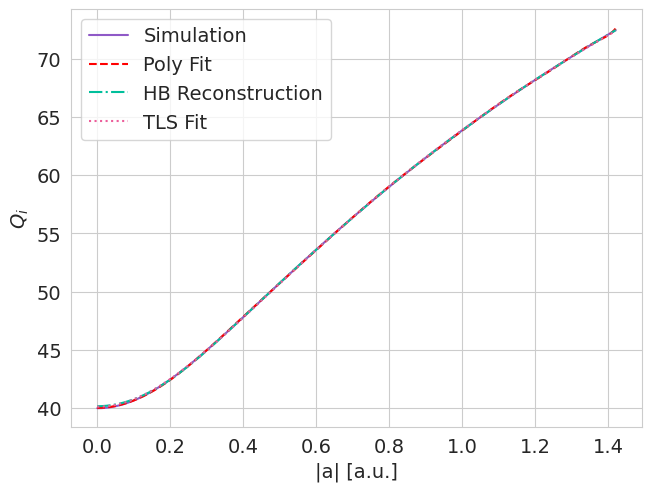

In [37]:
# Reconstructed damping using complex time-domain spectra
y_rec = 0
for coef_ind, coef_val in enumerate(d_rec):
    y_rec += coef_val * x_sim**(2 * coef_ind)
    
y_rec_d = 0
for coef_ind, coef_val in enumerate(d_rec_d):
    y_rec_d += coef_val * x_sim**(2 * coef_ind)

# curve fit of the reconstructed damping to get the tls parameters
popt = curve_fit(lambda x_sim, κ0_, κtls_, ac_, beta_: tls_function_2(x_sim, κ0_, κtls_, ac_, beta_, kext_rec, gain), 
                 x_sim, 
                 y_rec,
                 p0=[k0, ktls, ac, beta],
                 maxfev=10_000)

param_rec_hb_2 = np.append(f0_rec, [*popt[0][:-1], kext_rec, popt[0][-1]])

popt = curve_fit(lambda x_sim, κ0_, κtls_, ac_, beta_: tls_function_2(x_sim, κ0_, κtls_, ac_, beta_, kext_rec_d, gain), 
                 x_sim, 
                 y_rec,
                 p0=[k0, ktls, ac, beta],
                 maxfev=10_000)

param_rec_hb_d_2 = np.append(f0_rec_d, [*popt[0][:-1], kext_rec_d, popt[0][-1]])


print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15} {:<15}'.format('Parameter', 'Simulation', 'Reconstruction', 'Reconstruction 2') + '\033[0m')
print('{:<15} {:<15} {:<15} {:<15}'.format('kext', f'{kext:.3e}', f'{kext_rec:.3e}', f'{kext_rec_d:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('f0', f'{f0:.3e}', f'{f0_rec:.3e}', f'{f0_rec_d:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('κ0', f'{k0:.3e}', f'{param_rec_hb_2[1]:.3e}', f'{param_rec_hb_d_2[1]:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('κtls', f'{ktls:.3e}', f'{param_rec_hb_2[2]:.3e}', f'{param_rec_hb_d_2[2]:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('ac', f'{ac:.3e}', f'{param_rec_hb_2[3]:.3e}', f'{param_rec_hb_d_2[3]:.3e}'))
print('{:<15} {:<15} {:<15} {:<15}'.format('β', f'{beta:.3e}', f'{param_rec_hb_2[5]:.3e}', f'{param_rec_hb_d_2[5]:.3e}'))


# Plotting
fig, ax = plt.subplots(1)

ax.plot(x_sim, 1 / (y_sim - kext/2), label='Simulation')
ax.plot(x_sim, 1 / (y_fit - kext/2), 'r--', label='Poly Fit')
ax.plot(x_sim, 1 / (y_rec - kext_rec/2), '-.', label='HB Reconstruction')
ax.plot(x_sim, 1 / (tls_function_2(x_sim, *popt[0], kext_rec, gain) - kext_rec/2), ':', label='TLS Fit')

ax.set_xlabel('|a| [a.u.]')
ax.set_ylabel('$Q_i$')
ax.legend()

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-Sim-Qi_rec.png', dpi=300)

## Harmonic balance reconstruction by spectrum fitting

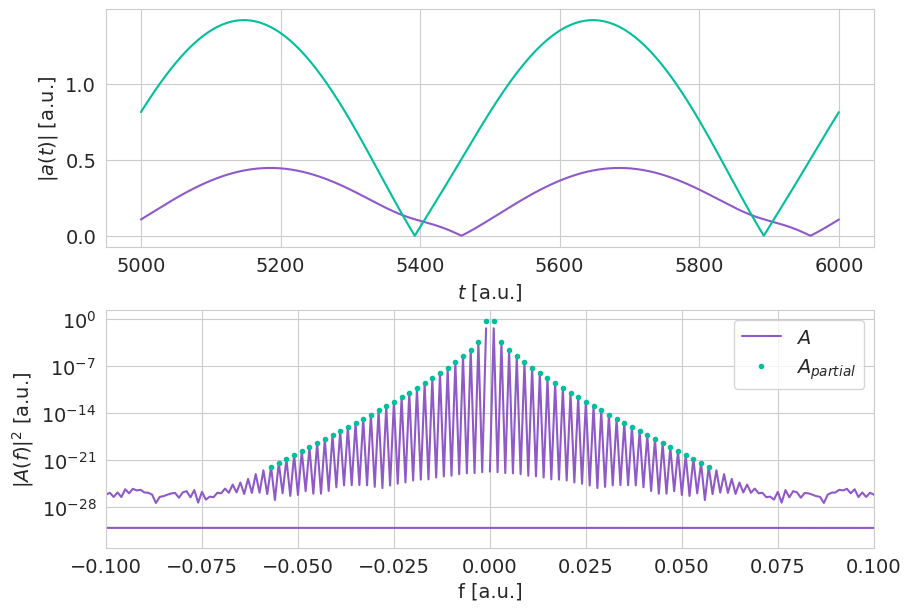

In [38]:
# Partial spectra for spectrum fitting reconstruction
verbose = True

# IMPs indices
drives_ind = -np.array([int(fd1 / df), int(fd2 / df)])
nimps = 28
nstep = int((fd2 - fd1) / df)
imps_ind = np.arange(drives_ind[1] - nimps*nstep, drives_ind[0] + nimps*nstep + nstep, nstep)

# partial spectra zero padded
Apartial_zp = np.zeros(len(Aout_2), dtype=complex)
Apartial_zp[imps_ind] = (Aout_2 / np.sqrt(gain) - np.exp(1.0j * phase_delay_rec) * Ain / np.sqrt(att_rec))[imps_ind]

# partial spectra in frequency and time domain
Apartial = (Aout_2 / np.sqrt(gain) - np.exp(1.0j * phase_delay_rec) * Ain / np.sqrt(att_rec))[imps_ind]
apartial = np.fft.ifft(Apartial_zp)
apartial *= len(apartial)
# partial input field
Ain_partial = np.exp(1.0j * phase_delay_rec) * Ain[imps_ind] / np.sqrt(att_rec)

# frequencies of the partial spectra
f_partial = f[imps_ind]

# sanity check
if verbose:
# Plot: steady-state fields in the time and frequency domain
    fig, ax = plt.subplots(2, figsize=(9, 6))

    # plot
    ax[0].plot(t, np.abs(aout_2))
    ax[0].plot(t, np.abs(apartial))
    ax[1].semilogy(f, np.abs(Aout_2)**2, label=r'$A$')
    ax[1].semilogy(f_partial, np.abs(Apartial)**2, '.', label=r'$A_{partial}$')

    # labels
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([-df*100, df*100])
    ax[1].legend()

    plt.show()

In [39]:
# Initial guess
noise = 0.2 * np.random.random_sample(6) - 0.01
# x0 = [f0 + noise[0], k0 + noise[1], ktls + noise[2], ac + noise[3], beta + noise[4], kext + noise[5]]
x0 = [f0, k0, ktls, ac, kext, beta]

constrained = True

if constrained:
    # Nelder-Mead (nm) algorithm
    res = scipy.optimize.minimize(error_func_nm_2, (x0[2:-1]), tol=1e-10)
    param_rec_sf_nm_2 = res.x

    # least squares or Levenberg-Marquardt algorithm
    res = scipy.optimize.least_squares(error_func_ls_2, x0[2:-1])
    param_rec_sf_ls_2 = res.x
    
    # residuals
    error_2 = error_func_nm_2([ktls, ac, kext])
    error_hb_2 = error_func_nm_2(param_rec_hb_2[2:-1])
    error_sf_nm_2 = error_func_nm_2(param_rec_sf_nm_2)
    error_sf_ls_2 = error_func_nm_2(param_rec_sf_ls_2)
    
    # print results
    print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('Parameter', 'Simulation', 'Pseudo-Matrix', 'Spectrum fitting', 'Spectrum fitting'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('', '', 'Inversion', '(Nelder-Mead)', '(Least squares)') + '\033[0m')
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('f0', f'{f0:.3e}', f'{param_rec_hb_2[0]:.3e}', f'{f0:.3e}', f'{f0:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κ0', f'{k0:.3e}', f'{param_rec_hb_2[1]:.3e}', f'{k0:.3e}', f'{k0:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κtls', f'{ktls:.3e}', f'{param_rec_hb_2[2]:.3e}', f'{param_rec_sf_nm_2[0]:.3e}', f'{param_rec_sf_ls_2[0]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('ac', f'{ac:.3e}', f'{param_rec_hb_2[3]:.3e}', f'{param_rec_sf_nm_2[1]:.3e}', f'{param_rec_sf_ls_2[1]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κext', f'{kext:.3e}', f'{param_rec_hb_2[4]:.3e}', f'{param_rec_sf_nm_2[2]:.3e}', f'{param_rec_sf_ls_2[2]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('β', f'{beta}', f'{param_rec_hb_2[5]:.3e}', f'{beta:.3e}', f'{beta:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('', '', '', '', ''))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('E', f'{error_2:.3e}', f'{error_hb_2:.3e}', f'{error_sf_nm_2:.3e}', f'{error_sf_ls_2:.3e}'))
    
else:
    # Nelder-Mead (nm) algorithm
    res = scipy.optimize.minimize(error_func_nm_2, (x0), tol=1e-10)
    param_rec_sf_nm_2 = res.x

    # least squares or Levenberg-Marquardt algorithm
    res = scipy.optimize.least_squares(error_func_ls_2, x0)
    param_rec_sf_ls_2 = res.x

    # residuals
    error_2 = error_func_nm_2([f0, k0, ktls, ac, beta, kext])
    error_hb_2 = error_func_nm_2(param_rec_hb_2)
    error_sf_nm_2 = error_func_nm_2(param_rec_sf_nm_2)
    error_sf_ls_2 = error_func_nm_2(param_rec_sf_ls_2)

    # print results
    print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('Parameter', 'Simulation', 'Pseudo-Matrix', 'Spectrum fitting', 'Spectrum fitting'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('', '', 'Inversion', '(Nelder-Mead)', '(Least squares)') + '\033[0m')
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('f0', f'{f0:.3e}', f'{param_rec_hb_2[0]:.3e}', f'{param_rec_sf_nm_2[0]:.3e}', f'{param_rec_sf_ls_2[0]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κ0', f'{k0:.3e}', f'{param_rec_hb_2[1]:.3e}', f'{param_rec_sf_nm_2[1]:.3e}', f'{param_rec_sf_ls_2[1]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κtls', f'{ktls:.3e}', f'{param_rec_hb_2[2]:.3e}', f'{param_rec_sf_nm_2[2]:.3e}', f'{param_rec_sf_ls_2[2]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('ac', f'{ac:.3e}', f'{param_rec_hb_2[3]:.3e}', f'{param_rec_sf_nm_2[3]:.3e}', f'{param_rec_sf_ls_2[3]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('β', f'{beta:.3e}', f'{param_rec_hb_2[4]:.3e}', f'{param_rec_sf_nm_2[4]:.3e}', f'{param_rec_sf_ls_2[4]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('κext', f'{kext:.3e}', f'{param_rec_hb_2[5]:.3e}', f'{param_rec_sf_nm_2[5]:.3e}', f'{param_rec_sf_ls_2[5]:.3e}'))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('', '', '', '', ''))
    print('{:<15} {:<15} {:<20} {:<20} {:<20}'.format('E', f'{error_2:.3e}', f'{error_hb_2:.3e}', f'{error_sf_nm_2:.3e}', f'{error_sf_ls_2:.3e}'))




RECONSTRUCTED PARAMETERS
Parameter       Simulation      Pseudo-Matrix        Spectrum fitting     Spectrum fitting    
                                Inversion            (Nelder-Mead)        (Least squares)     
f0              0.000e+00       1.036e-05            0.000e+00            0.000e+00           
κ0              8.000e-02       8.236e-02            8.000e-02            8.000e-02           
κtls            4.000e-02       3.748e-02            4.000e-02            4.000e-02           
ac              1.414e+00       1.500e+00            1.414e+00            1.414e+00           
κext            7.000e-02       7.000e-02            7.000e-02            7.000e-02           
β               0.3             3.421e-01            3.000e-01            3.000e-01           
                                                                                              
E               7.766e-10       1.147e-07            7.766e-10            7.766e-10           


### Parameter Dependence


#### Drive frequency sweep

We now perform a drive frequency sweep along the resonance.
In a notch configuration, we expect a dip in the output field when on-resonance. 
However, we observe a dip, meaning probably that the input-output relation it is not correct.

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
verbose = True

# drive frequency sweep
fd_start = -0.15
fd_stop = 0.15
n_start = int(round(fd_start / df))
n_stop = int(round(fd_stop / df))
n_arr = np.arange(n_start, n_stop + 1)
nr_freq = len(n_arr)
fd_arr = df * n_arr


# Empty arrays
kext_rec_i = np.zeros_like(fd_arr)
f0_rec_i = np.zeros_like(fd_arr)
k0_rec_i = np.zeros_like(fd_arr)
ktls_rec_i = np.zeros_like(fd_arr)
ac_rec_i = np.zeros_like(fd_arr)
beta_rec_i = np.zeros_like(fd_arr)

Aout_i_arr = np.zeros((len(fd_arr), int(fs/df)), dtype=complex)
aout_i_arr = np.zeros_like(Aout_i_arr)
ain_i_arr = np.zeros_like(Aout_i_arr)
Ain_i_arr = np.zeros_like(Aout_i_arr)

drive_ind_arr = np.zeros((len(fd_arr), 2), dtype=int)
imp_ind_arr = np.zeros((len(fd_arr), 2*nimps+2), dtype=int)

param_rec_hb_arr_2 = np.zeros((len(fd_arr), len(param_rec_hb)))

if constrained:
    param_rec_sf_nm_arr_2 = np.zeros_like(param_rec_hb_arr_2[:, 2:-1])
    param_rec_sf_ls_arr_2 = np.zeros_like(param_rec_hb_arr_2[:, 2:-1])
else:
    param_rec_sf_nm_arr_2 = np.zeros_like(param_rec_hb_arr_2)
    param_rec_sf_ls_arr_2 = np.zeros_like(param_rec_hb_arr_2)

# Simulation
with tqdm(total=len(fd_arr), ncols=80) as pbar:
    for fd_idx, fd_val in enumerate(fd_arr):
        
        # Drive frequencies
        fd1_val = fd_val - df
        fd2_val = fd_val + df

        # Intra-cavity field
        Aout_i_arr[fd_idx], aout_i_arr[fd_idx], f, t = hb.tls_simulation(time_=time,
                                                                         f0_=f0,
                                                                         k0_=k0,
                                                                         ktls_=ktls,
                                                                         ac_=ac,
                                                                         beta_=beta,
                                                                         F1_=F01,
                                                                         F2_=F02,
                                                                         fd1_=fd1_val,
                                                                         fd2_=fd2_val,
                                                                         kext_=kext,
                                                                         psi_=psi,
                                                                         phase_=phase_delay,
                                                                         gain_=gain,
                                                                         att_=att,
                                                                         y0_=y0,
                                                                         N_=N,
                                                                         dt_=dt,
                                                                         in_out=True
                                                                         )
        
        # Input field
        ain_i_arr[fd_idx] = F01 * (np.exp(-1j * 2 * np.pi * fd1_val * t) + np.exp(-1j * (2 * np.pi * fd2_val * t + psi)))
        Ain_i_arr[fd_idx] = np.fft.fft(ain_i_arr[fd_idx]) / len(ain_i_arr[fd_idx])
        
        # Drive indices
        drive_ind_arr[fd_idx] = -np.array([int(round(fd1_val / df, 1)), int(round(fd2_val / df, 1))])
        # IMPs indices
        nstep = drive_ind_arr[fd_idx, 0] - drive_ind_arr[fd_idx, 1]
        imp_ind_arr[fd_idx] = np.arange(drive_ind_arr[fd_idx, 1] - nimps*nstep,
                                        drive_ind_arr[fd_idx, 0] + nimps*nstep + nstep, 
                                        nstep)
        
        
        if verbose:
            # Reconstuction
            kext_rec_i[fd_idx], f0_rec_i[fd_idx], d_rec, _ = hb.tls_reconstruction(Aout_i_arr[fd_idx], 
                                                                                   phase_factor_rec * Ain_i_arr[fd_idx],
                                                                                   aout_i_arr[fd_idx], 
                                                                                   phase_factor_rec * ain_i_arr[fd_idx],
                                                                                   f, 
                                                                                   imp_ind_arr[fd_idx],
                                                                                   n,
                                                                                   np.angle(phase_factor_rec),
                                                                                   in_out=True,
                                                                                  )



            # Reconstructed damping using complex time-domain spectra
            xmax = np.max(np.abs(aout_i_arr[fd_idx] - phase_factor_sim * ain_i_arr[fd_idx]))
            x_sim = np.linspace(-xmax, xmax, 10000)
            y_rec = 0
            for coef_ind, coef_val in enumerate(d_rec):
                y_rec += coef_val * x_sim**(2 * coef_ind)

            # curve fit of the reconstructed damping to get the tls parameters
            popt = curve_fit(lambda x_sim, κ0_, κtls_, ac_, beta_: tls_function_2(x_sim, κ0_, κtls_, ac_, 0.3, kext_rec_i[fd_idx], gain), 
                             x_sim, 
                             y_rec,
                             p0=[k0, ktls, ac, beta],
                             maxfev=10_000)

            k0_rec_i[fd_idx] = popt[0][0]
            ktls_rec_i[fd_idx] = popt[0][1]
            ac_rec_i[fd_idx] = popt[0][2]
            beta_rec_i[fd_idx] = popt[0][3]
            
            param_rec_hb_arr_2[fd_idx] = f0_rec_i[fd_idx], k0_rec_i[fd_idx], ktls_rec_i[fd_idx], ac_rec_i[fd_idx], beta_rec_i[fd_idx], kext_rec_i[fd_idx]            
            
            # Spectrum fitting reconstruction
            imps_ind = imp_ind_arr[fd_idx]
            Apartial = (Aout_i_arr / np.sqrt(gain) - np.exp(1.0j * phase_delay_rec) * Ain_i_arr / np.sqrt(att_rec))[fd_idx, imps_ind]
    
            Apartial_zp = np.zeros(len(Aout_i_arr[fd_idx]), dtype=complex)
            Apartial_zp[imps_ind] = Apartial
            apartial = np.fft.ifft(Apartial_zp)
            apartial *= len(apartial)
            
            Ain_partial = np.exp(1.0j * phase_delay_rec) * Ain_i_arr[fd_idx, imps_ind] / np.sqrt(att_rec)
            
            # Initial guess
            if constrained:
                x0 = [ktls + noise[2], ac + noise[3], kext + noise[5]]
            else:
                x0 = [f0 + noise[0], k0 + noise[1], ktls + noise[2], ac + noise[3], kext + noise[4], beta + noise[5]]
            
            # Nelder-Mead algorithm
            res = scipy.optimize.minimize(error_func_nm_2, (x0), tol=1e-10)
            param_rec_sf_nm_arr_2[fd_idx] = res.x
            
            # least squares algorithm
            res = scipy.optimize.least_squares(error_func_ls_2, x0)
            param_rec_sf_ls_arr_2[fd_idx] = res.x
        
    
        pbar.update(1)

100%|█████████████████████████████████████████| 301/301 [08:26<00:00,  1.68s/it]


In [42]:
# Plot: steady-state fields in the time and frequency domain

def plot_sweep(fd_idx):
    # IMPs
    indices_ = imp_ind_arr[fd_idx]
    
    # Plotting
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.abs(aout_i_arr[fd_idx]))
    ax[0].plot(t, np.abs(ain_i_arr[fd_idx]))
    ax[1].semilogy(f, np.abs(Aout_i_arr[fd_idx])**2, label=r'$A_{out}$')
    ax[1].semilogy(f, np.abs(Ain_i_arr[fd_idx])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[indices_], np.abs(Aout_i_arr[fd_idx])[indices_]**2, '.', label=r'$A_{in}$')

    # labels
    ax[0].set_title(r'$f_c$' + f' = {fd_arr[fd_idx]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([-df*250, df*250])
    ax[1].set_ylim([np.min(np.abs(Aout_i_arr)**2)/10, np.max(np.abs(Aout_i_arr)**2)*10])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_sweep,
                 fd_idx=widgets.IntSlider(min=0,
                                          max=len(fd_arr)-1,
                                          step=1,
                                          description='fd ind',
                                         )
                )
plt.show()

interactive(children=(IntSlider(value=0, description='fd ind', max=300), Output()), _dom_classes=('widget-inte…

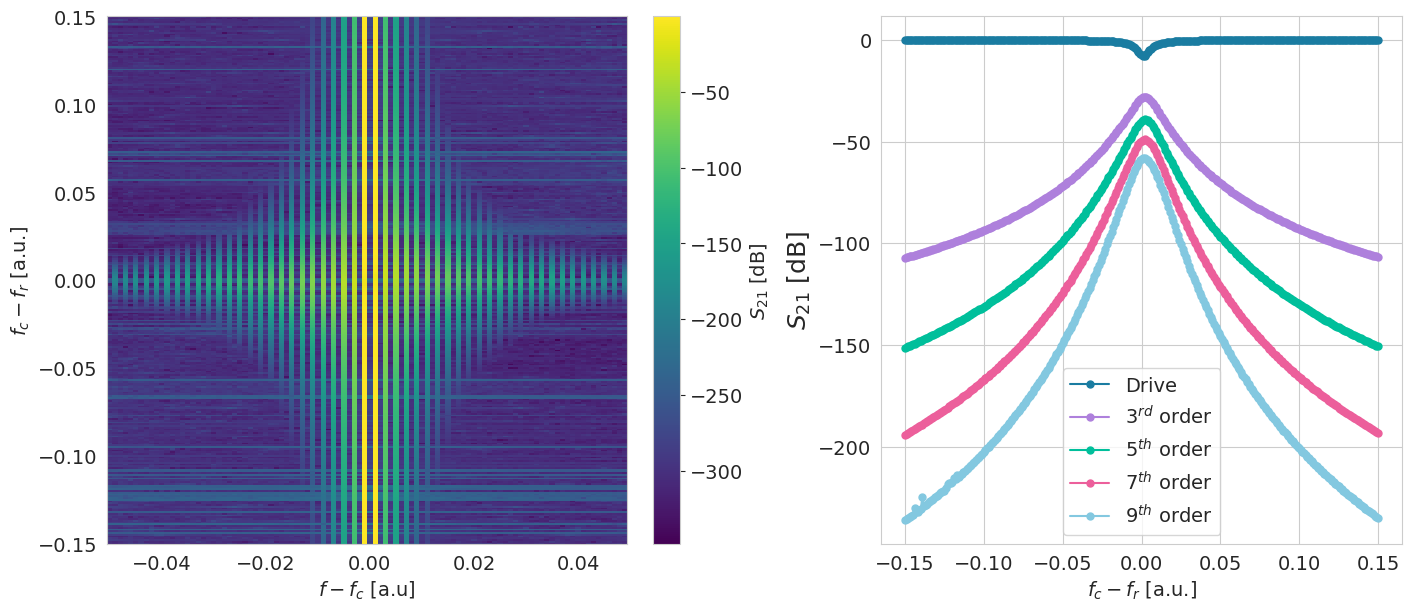

In [43]:
f_lim = int(0.05 / df)

spectra, freqs = arrange_spectra(Aout_i_arr/F01, f, fs, df, f_lim, fd_arr)

# 2D frequency sweep plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

fig, ax, cmap = plot_2D_freq_sweep(spectra, freqs, fd_arr, fig, ax)

fig.colorbar(cmap, ax=ax[0], label=r'$S_{21}$ [dB]')
ax[1].set_ylabel(r'$S_{21}$ [dB]', fontsize=18)

plt.show()

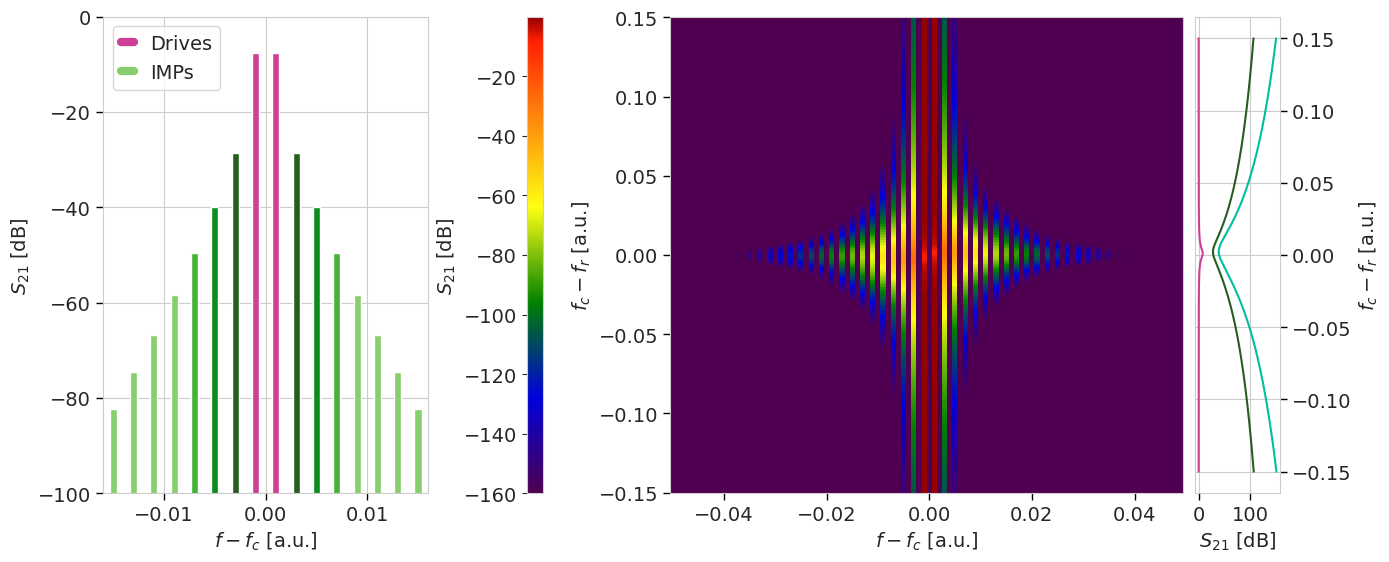

In [44]:
f_lim = int(0.05 / df)

spectra, frequencies = arrange_spectra(Aout_i_arr/F01, f, fs, df, f_lim, fd_arr)

# Plotting
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, 
                                  ncols=3, 
                                  figsize=(2*17.5/2.54, 2*7/2.54), 
                                  gridspec_kw={'width_ratios': [1.9, 3, 0.5]})

# Subplot 1
cut = int(len(fd_arr) / 2) # frequency point along which you take a line cut
axis_offset = 150
bar_width = 0.0007

# separate traces into odd (IMPs) and even (background).
odd_comb = np.array([frequencies[r] for r in range(1, len(frequencies), 2)])
odd_data = np.array([(spectra[cut, r]) for r in range(1, len(frequencies), 2)])

even_comb = np.array([frequencies[r] for r in range(0, len(frequencies), 2)])
even_data = np.array([(spectra[cut, r]) for r in range(0, len(frequencies), 2)])

# Bar plot
ax1.bar(odd_comb, 
        odd_data+axis_offset, 
        width=bar_width,
        bottom=-axis_offset,
        color='#87CE6E', 
        label='Higher orders')

ax1.bar([frequencies[int(len(frequencies)/2-1)], frequencies[int(len(frequencies)/2+1)]],
        [(spectra[cut, int(len(frequencies)/2-1)])+axis_offset, (spectra[cut, int(len(frequencies)/2+1)])+axis_offset],
         width=bar_width, 
         bottom=-axis_offset,
         color='#CE3F96',
         label='Drive') 
ax1.bar([frequencies[int(len(frequencies)/2-1-nstep)], frequencies[int(len(frequencies)/2+1+nstep)]],
        [(spectra[cut, int(len(frequencies)/2-1-nstep)])+axis_offset, (spectra[cut, int(len(frequencies)/2+1+nstep)]+axis_offset)],
         width=bar_width,
         bottom=-axis_offset,
         color='#275E20',
         label='$3^{rd}$ order IMP') 
ax1.bar([frequencies[int(len(frequencies)/2-1-2*nstep)], frequencies[int(len(frequencies)/2+1+2*nstep)]],
        [(spectra[cut, int(len(frequencies)/2-1-2*nstep)])+axis_offset, (spectra[cut, int(len(frequencies)/2+1+2*nstep)])+axis_offset],
         width=bar_width,
         bottom=-axis_offset,
         color='#0B8D1E',
         label='$5^{th}$ order IMP')
ax1.bar([frequencies[int(len(frequencies)/2-1-3*nstep)], frequencies[int(len(frequencies)/2+1+3*nstep)]],
        [(spectra[cut, int(len(frequencies)/2-1-3*nstep)])+axis_offset, (spectra[cut, int(len(frequencies)/2+1+3*nstep)])+axis_offset],
         width=bar_width,
         bottom=-axis_offset,
         color='#45B336',
         label = '$7^{th}$ order IMP')
# background
# ax1.bar(even_comb,
#         even_data+axis_offset,
#         width=bar_width,
#         bottom=-axis_offset,
#         color='#83C8E0',
#         label='Background')        

# labels
ax1.set_xlim([-0.016, 0.016])
ax1.set_ylim([-100, 0])
ax1.set_xlabel(r'$f - f_c$ [a.u.]')
ax1.set_ylabel(r'$S_{21}$ [dB]')
ax1.tick_params(direction='out', length=5, width=1, color='black', tickdir='out', left=True, bottom=True)

# get handles and labels
handles, labels = fig.gca().get_legend_handles_labels()

# legend
order = [1, 2, 3, 4, 0, 5]
handles = ['Drives', 'IMPs']
lines = [Line2D([0], [0], color='#CE3F96', lw=6),
         Line2D([0], [0], color='#87CE6E', lw=6)]
ax1.legend(lines, handles, handlelength=.7, loc='upper left')


# Subplot 2
cmap = sns.color_palette("Reds_r", 5)

zmax = np.max(spectra)
zmin = -160
# zmin = np.min(spectra)

mappable = ax2.pcolormesh(frequencies, fd_arr, spectra, cmap=cmyt.cm.algae, vmax=zmax, vmin=zmin, shading='auto', rasterized=True)

cb = fig.colorbar(mappable, ax=ax2, location='left', aspect=30)
cb.set_label(r'$S_{21}$ [dB]')
ax2 .set_xlabel(r'$f - f_c$ [a.u.]')
ax2.set_ylabel(r'$f_c - f_r$ [a.u.]')
ax2.tick_params(direction='out', length=5, width=1, color='black', tickdir='out', left=True, bottom=True)

# Subplot 3
# the base transformation for turning the plot 90 degrees
base = fig.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

# define transformed line
ax3.plot(fd_arr, spectra[:, int(len(frequencies)/2+1)], transform=rot+base, c='#CE3F96', label=r'$f_{2}$') 
ax3.plot(fd_arr, spectra[:, int(len(frequencies)/2+1+nstep)], transform=rot+base, c='#275E20',label=r'$f_{3}$')
ax3.plot(fd_arr, spectra[:, int(len(frequencies)/2+1+2*nstep)], transform=rot+base, c='#00BF9B',label=r'$f_{5}$')

# labels
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax3.set_ylabel(r'$f_c - f_r$ [a.u.]')
ax3.set_xlabel(r'$S_{21}$ [dB]')
ax3.tick_params(direction='out', length=5, width=1, color='black', tickdir='out', left=False, bottom=True)
# ax3.legend(ncol=3)

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-Freq_sweep.pdf', dpi=300)

We plot the reconstructed parameters as a function of the center frequency.

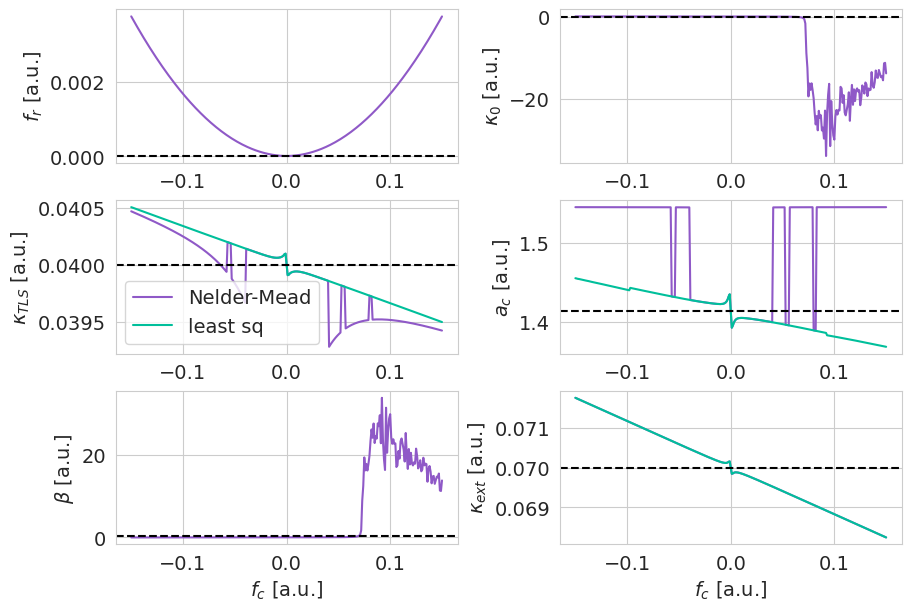

In [45]:
# Plot reconstructed parameters
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

if constrained:
    
    ax[0, 0].plot(fd_arr, param_rec_hb_arr_2[:, 0])
    ax[0, 0].axhline(f0, ls='--', c='black')

    ax[0, 1].plot(fd_arr, param_rec_hb_arr_2[:, 1])
    ax[0, 1].axhline(k0, ls='--', c='black')
    
    # ax[1, 0].plot(fd_arr, param_rec_hb_arr_2[:, 0], label='matrix inv')
    ax[1, 0].plot(fd_arr, param_rec_sf_nm_arr_2[:, 0], label='Nelder-Mead')
    ax[1, 0].plot(fd_arr, param_rec_sf_ls_arr_2[:, 0], label='least sq')
    ax[1, 0].axhline(ktls, ls='--', c='black')

    # ax[1, 1].plot(fd_arr, param_rec_hb_arr_2[:, 1])
    ax[1, 1].plot(fd_arr, param_rec_sf_nm_arr_2[:, 1])
    ax[1, 1].plot(fd_arr, param_rec_sf_ls_arr_2[:, 1])
    ax[1, 1].axhline(ac, ls='--', c='black')

    ax[2, 0].plot(fd_arr, param_rec_hb_arr_2[:, 2])
    ax[2, 0].axhline(beta, ls='--', c='black')

    # ax[2, 1].plot(fd_arr, param_rec_hb_arr_2[:, 3])
    ax[2, 1].plot(fd_arr, param_rec_sf_nm_arr_2[:, 2])
    ax[2, 1].plot(fd_arr, param_rec_sf_ls_arr_2[:, 2])
    ax[2, 1].axhline(kext, ls='--', c='black')

else:
    
    ax[0, 0].plot(fd_arr, param_rec_hb_arr_2[:, 0])
    ax[0, 0].plot(fd_arr, param_rec_sf_nm_arr_2[:, 0])
    ax[0, 0].plot(fd_arr, param_rec_sf_ls_arr_2[:, 0])
    ax[0, 0].axhline(f0, ls='--', c='black')

    ax[0, 1].plot(fd_arr, param_rec_hb_arr_2[:, 1])
    ax[0, 1].plot(fd_arr, param_rec_sf_nm_arr_2[:, 1])
    ax[0, 1].plot(fd_arr, param_rec_sf_ls_arr_2[:, 1])
    ax[0, 1].axhline(k0, ls='--', c='black')

    ax[1, 0].plot(fd_arr, param_rec_hb_arr_2[:, 2], label='matrix inv')
    ax[1, 0].plot(fd_arr, param_rec_sf_nm_arr_2[:, 2], label='Nelder-Mead')
    ax[1, 0].plot(fd_arr, param_rec_sf_ls_arr_2[:, 2], label='least sq')
    ax[1, 0].axhline(ktls, ls='--', c='black')

    ax[1, 1].plot(fd_arr, param_rec_hb_arr_2[:, 3])
    ax[1, 1].plot(fd_arr, param_rec_sf_nm_arr_2[:, 3])
    ax[1, 1].plot(fd_arr, param_rec_sf_ls_arr_2[:, 3])
    ax[1, 1].axhline(ac, ls='--', c='black')

    ax[2, 0].plot(fd_arr, param_rec_hb_arr_2[:, 4])
    ax[2, 0].plot(fd_arr, param_rec_sf_nm_arr_2[:, 4])
    ax[2, 0].plot(fd_arr, param_rec_sf_ls_arr_2[:, 4])
    ax[2, 0].axhline(beta, ls='--', c='black')

    ax[2, 1].plot(fd_arr, param_rec_hb_arr_2[:, 5])
    ax[2, 1].plot(fd_arr, param_rec_sf_nm_arr_2[:, 5])
    ax[2, 1].plot(fd_arr, param_rec_sf_ls_arr_2[:, 5])
    ax[2, 1].axhline(kext, ls='--', c='black')

# labels
ax[2, 0].set_xlabel('$f_c$ [a.u.]')
ax[2, 1].set_xlabel('$f_c$ [a.u.]')
ax[0, 0].set_ylabel('$f_r$ [a.u.]')
ax[1, 0].set_ylabel('$\kappa_{TLS}$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$a_c$ [a.u.]')
ax[2, 0].set_ylabel(r'$\beta$ [a.u.]')
ax[2, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')
ax[1, 0].legend()

plt.show()

#### Power sweep

In the same way, we perform a drive power sweep while calculating the output field spectra, obatining:

In [46]:
verbose = True

# drive parameters
F01_arr = np.logspace(-0.5, 2, 200)  # drive 1 amplitude
F01_arr = np.logspace(np.log10(np.sqrt(2)/65), 2, 200)

nimps = 100
nstep = int((fd2 - fd1) / df)
imps_ind = np.arange(drives_ind[1] - nimps*nstep, drives_ind[0] + nimps*nstep + nstep, nstep)

# Empty arrays
kext_rec_ii = np.zeros_like(F01_arr)
f0_rec_ii = np.zeros_like(F01_arr)
k0_rec_ii = np.zeros_like(F01_arr)
ktls_rec_ii = np.zeros_like(F01_arr)
ac_rec_ii = np.zeros_like(F01_arr)
beta_rec_ii = np.zeros_like(F01_arr)

Aout_ii_arr = np.zeros((len(F01_arr), int(fs/df)), dtype=complex)
aout_ii_arr = np.zeros_like(Aout_ii_arr)
ain_ii_arr = np.zeros_like(Aout_ii_arr)
Ain_ii_arr = np.zeros_like(Aout_ii_arr)

param_rec_hb_arr_3 = np.zeros((len(F01_arr), len(param_rec_hb)))

if constrained:
    param_rec_sf_nm_arr_3 = np.zeros_like(param_rec_hb_arr_3[:, 2:-1])
    param_rec_sf_ls_arr_3 = np.zeros_like(param_rec_hb_arr_3[:, 2:-1])
else:
    param_rec_sf_nm_arr_3 = np.zeros_like(param_rec_hb_arr_3)
    param_rec_sf_ls_arr_3 = np.zeros_like(param_rec_hb_arr_3)

# Simulation
with tqdm(total=len(F01_arr), ncols=80) as pbar:
    for F0_idx, F0_val in enumerate(F01_arr):

        # output field
        Aout_ii_arr[F0_idx], aout_ii_arr[F0_idx], f, t = hb.tls_simulation(time_=time,
                                                                           f0_=f0,
                                                                           k0_=k0,
                                                                           ktls_=ktls,
                                                                           ac_=ac,
                                                                           beta_=beta,
                                                                           F1_=F0_val,
                                                                           F2_=F0_val,
                                                                           fd1_=fd1,
                                                                           fd2_=fd2,
                                                                           kext_=kext,
                                                                           psi_=psi,
                                                                           phase_=phase_delay,
                                                                           gain_=gain,
                                                                           att_=att,
                                                                           y0_=y0,
                                                                           N_=N,
                                                                           dt_=dt,
                                                                           in_out=True,
                                                                           )
        
        # input field
        ain_ii_arr[F0_idx] = F0_val * (np.exp(-1j * 2 * np.pi * fd1 * t) + np.exp(-1j * (2 * np.pi * fd2 * t + psi)))
        Ain_ii_arr[F0_idx] = np.fft.fft(ain_ii_arr[F0_idx]) / len(ain_ii_arr[F0_idx])

        
        if verbose:
            # Reconstuction
            kext_rec_ii[F0_idx], f0_rec_ii[F0_idx], d_rec, _ = hb.tls_reconstruction(Aout_ii_arr[F0_idx], 
                                                                                     phase_factor_rec * Ain_ii_arr[F0_idx],
                                                                                     aout_ii_arr[F0_idx], 
                                                                                     phase_factor_rec * ain_ii_arr[F0_idx],
                                                                                     f, 
                                                                                     imps_ind,
                                                                                     n,
                                                                                     np.angle(phase_factor_rec),
                                                                                     in_out=True,
                                                                                    )

            # Reconstructed damping using complex time-domain spectra
            xmax = np.max(np.abs(aout_ii_arr[F0_idx] - phase_factor_sim * ain_ii_arr[F0_idx]))
            x_sim = np.linspace(-xmax, xmax, 10000)
            y_recon = 0
            for coef_ind, coef_val in enumerate(d_rec):
                y_recon += coef_val * x_sim**(2 * coef_ind)

            # curve fit of the reconstructed damping to get the tls parameters
            popt = curve_fit(lambda x_sim, κ0_, κtls_, ac_, beta_: tls_function_2(x_sim, κ0_, κtls_, ac_, 0.3, kext_rec_ii[F0_idx], gain), 
                             x_sim, 
                             y_rec,
                             p0=[k0, ktls, ac, beta],
                             maxfev=10_000)

            k0_rec_ii[F0_idx] = popt[0][0]
            ktls_rec_ii[F0_idx] = popt[0][1]
            ac_rec_ii[F0_idx] = popt[0][2]
            beta_rec_ii[F0_idx] = popt[0][3]
            
            param_rec_hb_arr_3[F0_idx] = f0_rec_ii[F0_idx], k0_rec_ii[F0_idx], ktls_rec_ii[F0_idx], ac_rec_ii[F0_idx], beta_rec_ii[F0_idx], kext_rec_ii[F0_idx]
        
                    
            # Spectrum fitting reconstruction
            Apartial = (Aout_ii_arr / np.sqrt(gain) - np.exp(1.0j * phase_delay_rec) * Ain_ii_arr / np.sqrt(att_rec))[F0_idx, imps_ind]
    
            Apartial_zp = np.zeros(len(Aout_ii_arr[F0_idx]), dtype=complex)
            Apartial_zp[imps_ind] = Apartial
            apartial = np.fft.ifft(Apartial_zp)
            apartial *= len(apartial)
            
            Ain_partial = np.exp(1.0j * phase_delay_rec) * Ain_ii_arr[F0_idx, imps_ind] / np.sqrt(att_rec)

            # Initial guess
            if constrained:
                x0 = [ktls, ac, kext]
            else:
                x0 = [f0, k0, ktls, ac, kext, beta]

            # Nelder-Mead algorithm
            res = scipy.optimize.minimize(error_func_nm_2, (x0), tol=1e-10)
            param_rec_sf_nm_arr_3[F0_idx] = res.x

            # least squares algorithm
            res = scipy.optimize.least_squares(error_func_ls_2, x0)
            param_rec_sf_ls_arr_3[F0_idx] = res.x

        pbar.update(1)

100%|█████████████████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


In [47]:
# Plot: steady-state fields in the time and frequency domain

def plot_power_sweep(F0_ind):
    
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.abs(aout_ii_arr[F0_ind]))
    ax[0].plot(t, np.abs(ain_ii_arr[F0_ind]))
    ax[1].semilogy(f, np.abs(Aout_ii_arr[F0_ind])**2, label=r'$A_{out}$')
    ax[1].semilogy(f, np.abs(Ain_ii_arr[F0_ind])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[imps_ind], np.abs(Aout_ii_arr[F0_ind])[imps_ind]**2, '.', label=r'$A_{IMP}$')
#     ax[1].axvline(f[len(f)//2])

    # labels
    ax[0].set_title(r'$F_0$' + f' = {F01_arr[F0_ind]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A|^2$ [a.u.]')
    ax[1].set_xlim([-df*200, df*200])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_power_sweep,
                 F0_ind=widgets.IntSlider(min=0,
                                          max=len(F01_arr)-1,
                                          step=1,
                                          description='F0 ind',
                                         )
                )


plt.show()

interactive(children=(IntSlider(value=0, description='F0 ind', max=199), Output()), _dom_classes=('widget-inte…

We plot the strength of the first four IMPs, obtaining the same dependence as for the intra-cavity field. 
Notice that we are now pplotting the output field.

0.4304248015485154 0.4476293591781551 0.46599094071860686 0.486121528663452
-3.065445207968853 -3.8867593983643163 -4.503590942227952 -5.0180631345158355


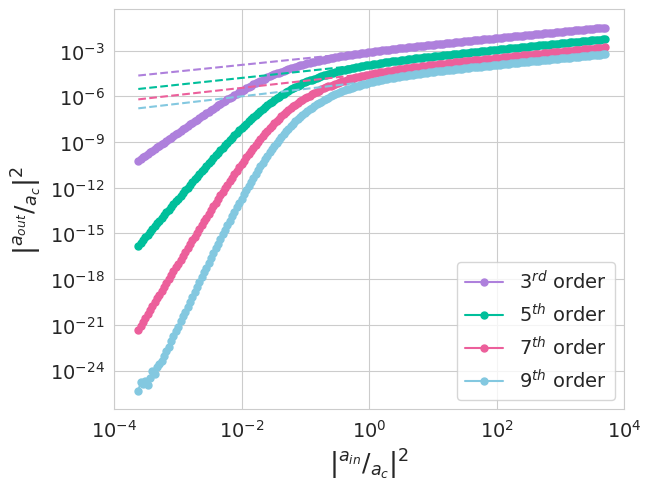

In [48]:
verbose = False

# Linear fits
cutoff = 103

# Plot drive power dependence
fig, ax = plt.subplots(1)

fig, ax = plot_power_dependence(Aout_ii_arr/ac, F01_arr**2/ac**2, fs, df, drives_ind, nstep, cutoff)

ax.set_ylabel(r'$\left| ^{a_{out}}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlabel(r'$\left| ^{a_{in}}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlim(1e-4, 1e4)
# ax.set_ylim(1e-16, 1e4)
ax.legend(loc='lower right')

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-Pow_sweep.pdf', dpi=300)

eventually, we plot the reconstructed parameters as a function of the drive amplitudes.
We notice that the harmonic balance fails at high powers.
This is expected since the non-linearity is stronger, and hence we need more IMPs to be able to reconstruct the system.

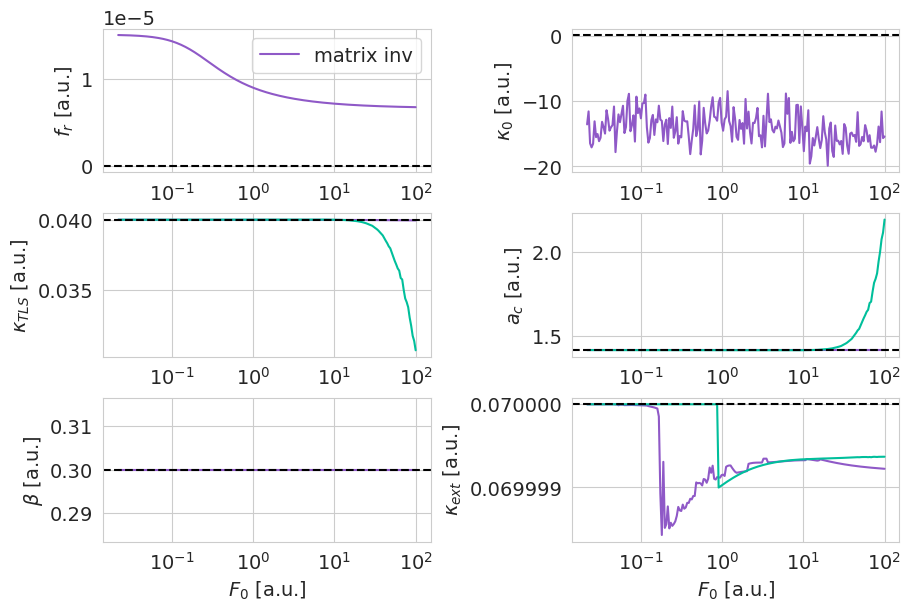

In [49]:
# Plot reconstructed parameters
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

if constrained:
    
    ax[0, 0].semilogx(F01_arr, param_rec_hb_arr_3[:, 0], label='matrix inv')
    ax[0, 0].axhline(f0, ls='--', c='black')

    ax[0, 1].semilogx(F01_arr, param_rec_hb_arr_3[:, 1])
    ax[0, 1].axhline(k0, ls='--', c='black')

    # ax[1, 0].semilogx(F01_arr, param_rec_hb_arr_3[:, 2])
    ax[1, 0].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 0])
    ax[1, 0].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 0])
    ax[1, 0].axhline(ktls, ls='--', c='black')

    # ax[1, 1].semilogx(F01_arr, param_rec_hb_arr_3[:, 3])
    ax[1, 1].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 1])
    ax[1, 1].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 1])
    ax[1, 1].axhline(ac, ls='--', c='black')

    ax[2, 0].semilogx(F01_arr, param_rec_hb_arr_3[:, 4])
    ax[2, 0].axhline(beta, ls='--', c='black')

    # ax[2, 1].semilogx(F01_arr, param_rec_hb_arr_3[:, 5])
    ax[2, 1].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 2])
    ax[2, 1].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 2])
    ax[2, 1].axhline(kext, ls='--', c='black')

else:    

    ax[0, 0].semilogx(F01_arr, param_rec_hb_arr_3[:, 0], label='matrix inv')
    ax[0, 0].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 0], label='Nelder-Mead')
    ax[0, 0].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 0], label='least sq')
    ax[0, 0].axhline(f0, ls='--', c='black')

    ax[0, 1].semilogx(F01_arr, param_rec_hb_arr_3[:, 1])
    ax[0, 1].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 1])
    ax[0, 1].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 1])
    ax[0, 1].axhline(k0, ls='--', c='black')

    ax[1, 0].semilogx(F01_arr, param_rec_hb_arr_3[:, 2])
    ax[1, 0].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 2])
    ax[1, 0].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 2])
    ax[1, 0].axhline(ktls, ls='--', c='black')

    ax[1, 1].semilogx(F01_arr, param_rec_hb_arr_3[:, 3])
    ax[1, 1].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 3])
    ax[1, 1].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 3])
    ax[1, 1].axhline(ac, ls='--', c='black')

    ax[2, 0].semilogx(F01_arr, param_rec_hb_arr_3[:, 4])
    ax[2, 0].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 4])
    ax[2, 0].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 4])
    ax[2, 0].axhline(beta, ls='--', c='black')

    ax[2, 1].semilogx(F01_arr, param_rec_hb_arr_3[:, 5])
    ax[2, 1].semilogx(F01_arr, param_rec_sf_nm_arr_3[:, 5])
    ax[2, 1].semilogx(F01_arr, param_rec_sf_ls_arr_3[:, 5])
    ax[2, 1].axhline(kext, ls='--', c='black')

# labels
ax[2, 0].set_xlabel('$F_0$ [a.u.]')
ax[2, 1].set_xlabel('$F_0$ [a.u.]')
ax[0, 0].set_ylabel('$f_r$ [a.u.]')
ax[1, 0].set_ylabel('$\kappa_{TLS}$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$a_c$ [a.u.]')
ax[2, 0].set_ylabel(r'$\beta$ [a.u.]')
ax[2, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')
ax[0, 0].legend()

plt.show()

#### $\beta$ and power sweep

We eventually perform a $\beta$ sweep together with a drive power sweep.

In [50]:
# drive parameters
F1_arr = np.logspace(-2, 2, 200)  # drive 1 amplitude

beta_arr = np.linspace(0, 1, 11)


# Empty arrays
Aout_iii_arr = np.zeros((len(beta_arr), len(F1_arr), int(fs/df)), dtype=complex)
aout_iii_arr = np.zeros_like(Aout_iii_arr)
ain_iii_arr = np.zeros_like(Aout_iii_arr)
Ain_iii_arr = np.zeros_like(Aout_iii_arr)

# Simulation
with tqdm(total=len(beta_arr) * len(F1_arr), ncols=80) as pbar:
    for beta_idx, beta_val in enumerate(beta_arr):
        
        for F0_idx, F0_val in enumerate(F1_arr):

            # run the integrator
            Aout_iii_arr[beta_idx, F0_idx], aout_iii_arr[beta_idx, F0_idx], f, t = hb.tls_simulation(time_=time,
                                                                                                     f0_=f0,
                                                                                                     k0_=k0,
                                                                                                     ktls_=ktls,
                                                                                                     ac_=ac,
                                                                                                     beta_=beta_val,
                                                                                                     F1_=F0_val,
                                                                                                     F2_=F0_val,
                                                                                                     fd1_=fd1,
                                                                                                     fd2_=fd2,
                                                                                                     kext_=kext,
                                                                                                     psi_=psi,
                                                                                                     phase_=phase_delay,
                                                                                                     gain_=gain,
                                                                                                     att_=att,
                                                                                                     y0_=y0,
                                                                                                     N_=N,
                                                                                                     dt_=dt,
                                                                                                     in_out=True
                                                                                                     )

            # input field
            ain_iii_arr[beta_idx, F0_idx] = F0_val * (np.exp(-1j * 2 * np.pi * fd1 * t) + np.exp(-1j * (2 * np.pi * fd2 * t + psi)))
            Ain_iii_arr[beta_idx, F0_idx] = np.fft.fft(ain_iii_arr[beta_idx, F0_idx]) / len(ain_iii_arr[beta_idx, F0_idx])

            pbar.update(1)

100%|███████████████████████████████████████| 2200/2200 [18:49<00:00,  1.95it/s]


In [51]:
# Plot: steady-state fields in the time and frequency domain

def plot_power_beta_sweep(beta_idx, F0_idx):
    
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.abs(aout_iii_arr[beta_idx, F0_idx]))
    ax[0].plot(t, np.abs(ain_iii_arr[beta_idx, F0_idx]))
    ax[1].semilogy(f, np.abs(Aout_iii_arr[beta_idx, F0_idx])**2, label=r'$A_{out}$')
    ax[1].semilogy(f, np.abs(Ain_iii_arr[beta_idx, F0_idx])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[imps_ind], np.abs(Aout_iii_arr[beta_idx, F0_idx])[imps_ind]**2, '.', label=r'$A_{IMP}$')
#     ax[1].axvline(f[len(f)//2])

    # labels
    ax[0].set_title(r'$F_0$' + f' = {F1_arr[F0_idx]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$|a(t)|$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A|^2$ [a.u.]')
    ax[1].set_xlim([-df*200, df*200])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_power_beta_sweep,
                 beta_idx=widgets.IntSlider(min=0,
                                            max=len(beta_arr)-1,
                                            step=1,
                                            description='beta ind',
                                           ),
                 F0_idx=widgets.IntSlider(min=0,
                                          max=len(F1_arr)-1,
                                          step=1,
                                          description='F0 ind',
                                         )
                )


plt.show()

interactive(children=(IntSlider(value=0, description='beta ind', max=10), IntSlider(value=0, description='F0 i…

We observe that the slope in the saturation regime of the TLSs depends on the value of the exponent $\beta$.

In [52]:
def plot_beta_sweep(beta_idx):

    # Plot drive power dependence
    fig, ax = plt.subplots(1)

    ax.loglog(F1_arr**2, np.abs(Aout_iii_arr[beta_idx, :, drives_ind[0]])**2, 'o-',label="Drive", c='#1A7CA1', markersize=5)
    ax.loglog(F1_arr**2, np.abs(Aout_iii_arr[beta_idx, :, int(fs/df/2)])**2, 'o-', label="Background", c = '#7D787A', markersize=5)
    ax.loglog(F1_arr**2, np.abs(Aout_iii_arr[beta_idx, :, drives_ind[1]-nstep])**2, 'o-', label=r"$3^{rd}$ order", c='#AE80DC', markersize=5)
    ax.loglog(F1_arr**2, np.abs(Aout_iii_arr[beta_idx, :, drives_ind[1]-2*nstep])**2, 'o-', label=r"$5^{th}$ order", c='#00BF9B', markersize=5)
    ax.loglog(F1_arr**2, np.abs(Aout_iii_arr[beta_idx, :, drives_ind[1]-3*nstep])**2, 'o-', label=r"$7^{th}$ order", c='#EC5F9B', markersize=5)
    ax.loglog(F1_arr**2, np.abs(Aout_iii_arr[beta_idx, :, drives_ind[1]-4*nstep])**2, 'o-', label=r"$9^{th}$ order", c='#83C8E0', markersize=5)

    ax.set_ylabel('$|A|^2$ [a.u.]')
    ax.set_xlabel('$F_0^2$ [a.u.]')
    ax.set_xlim(5e-5, 1e8)
    ax.set_ylim(1e-40, 1e5)
    ax.legend(loc='upper right')
    
    
# Interactive layout  
widgets.interact(plot_beta_sweep,
                 beta_idx=widgets.IntSlider(min=0,
                                            max=len(beta_arr)-1,
                                            step=1,
                                            description='beta ind',
                                           )
                )

plt.show()

interactive(children=(IntSlider(value=0, description='beta ind', max=10), Output()), _dom_classes=('widget-int…

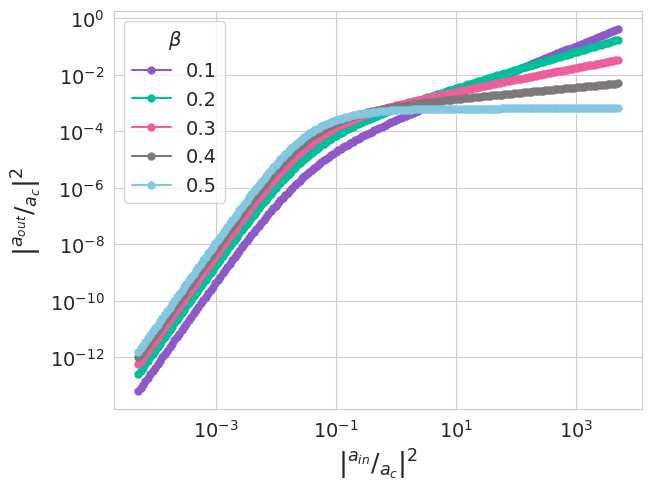

In [53]:
fig, ax = plt.subplots(1)

for beta_idx, beta_val in enumerate(beta_arr[1:6]):
    ax.loglog((F1_arr/ac)**2, (np.abs(Aout_iii_arr[beta_idx+1, :, drives_ind[1]-nstep])/ac)**2, 'o-',label=f'{beta_val:.1f}', markersize=5)

ax.set_ylabel(r'$\left| ^{a_{out}}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlabel(r'$\left| ^{a_{in}}/_{a_c} \right|^2$', fontsize=18)
ax.legend(title=r'$\beta$', loc='best')
    
# plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-Beta_sweep.pdf')
# plt.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-Beta_sweep.svg', 
#             format='svg', dpi=600)

plt.show()

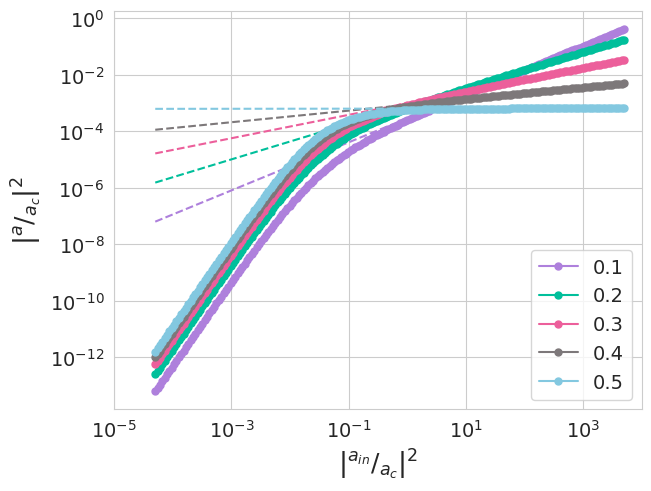

In [54]:
def plot_beta_dependence(A_, P_, fs_, df_, drives_ind_, nstep_, cutoff_):
    
    # Slope of the linear regime
    slope_1 = np.log10(np.abs(A_[1, -1, drives_ind_[1]-nstep_])**2 / np.abs(A_[1, cutoff_, drives_ind_[1]-nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_2 = np.log10(np.abs(A_[2, -1, drives_ind_[1]-nstep_])**2 / np.abs(A_[2, cutoff_, drives_ind_[1]-nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_3 = np.log10(np.abs(A_[3, -1, drives_ind_[1]-nstep_])**2 / np.abs(A_[3, cutoff_, drives_ind_[1]-nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_4 = np.log10(np.abs(A_[4, -1, drives_ind_[1]-nstep_])**2 / np.abs(A_[4, cutoff_, drives_ind_[1]-nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])
    slope_5 = np.log10(np.abs(A_[5, -1, drives_ind_[1]-nstep_])**2 / np.abs(A_[5, cutoff_, drives_ind_[1]-nstep_])**2) / np.log10(P_[-1] / P_[cutoff_])

    n_1 = np.log10(np.abs(A_[1, -1, drives_ind_[1]-nstep_])**2 / P_[-1]**(slope_1))
    n_2 = np.log10(np.abs(A_[2, -1, drives_ind_[1]-nstep_])**2 / P_[-1]**(slope_2))
    n_3 = np.log10(np.abs(A_[3, -1, drives_ind_[1]-nstep_])**2 / P_[-1]**(slope_3))
    n_4 = np.log10(np.abs(A_[4, -1, drives_ind_[1]-nstep_])**2 / P_[-1]**(slope_4))
    n_5 = np.log10(np.abs(A_[5, -1, drives_ind_[1]-nstep_])**2 / P_[-1]**(slope_5))
    
    slopes = np.array([slope_1, slope_2, slope_3, slope_4, slope_5])
    
    # Plot power dependence
    # ax.loglog(P_, np.abs(A_[:, drives_ind_[0]])**2, 'o-',label="Drive", c='#1A7CA1', markersize=5)
    ax.loglog(P_, np.abs(A_[1, :, drives_ind_[1]-nstep_])**2, 'o-', label=r"0.1", c='#AE80DC', markersize=5)
    ax.loglog(P_, 10**(slope_1*np.log10(P_) + n_1), ls='--', c='#AE80DC')
    ax.loglog(P_, np.abs(A_[2, :, drives_ind_[1]-nstep_])**2, 'o-', label=r"0.2", c='#00BF9B', markersize=5)
    ax.loglog(P_, 10**(slope_2*np.log10(P_) + n_2), ls='--', c='#00BF9B')
    ax.loglog(P_, np.abs(A_[3, :, drives_ind_[1]-nstep_])**2, 'o-', label=r"0.3", c='#EC5F9B', markersize=5)
    ax.loglog(P_, 10**(slope_3*np.log10(P_) + n_3), ls='--', c='#EC5F9B')
    ax.loglog(P_, np.abs(A_[4, :, drives_ind_[1]-nstep_])**2, 'o-', label=r"0.4", c='#7D787A', markersize=5)
    ax.loglog(P_, 10**(slope_4*np.log10(P_) + n_4), ls='--', c='#7D787A')
    ax.loglog(P_, np.abs(A_[5, :, drives_ind_[1]-nstep_])**2, 'o-', label=r"0.5", c='#83C8E0', markersize=5)
    ax.loglog(P_, 10**(slope_5*np.log10(P_) + n_5), ls='--', c='#83C8E0')
    
    if verbose:
        ax.axvline(P_[cutoff], ls='--', c='black')
        print(slope_1, slope_2, slope_3, slope_4, slope_5)
        print(n_1, n_2, n_3, n_4, n_5)
        
    return fig, ax, slopes



verbose = False

# Linear fits
cutoff = 140

# Plot drive power dependence
fig, ax = plt.subplots(1)

fig, ax, s = plot_beta_dependence(Aout_iii_arr/ac, F1_arr**2/ac**2, fs, df, drives_ind, nstep, cutoff)

ax.set_ylabel(r'$\left| ^{a}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlabel(r'$\left| ^{a_{in}}/_{a_c} \right|^2$', fontsize=18)
ax.set_xlim(1e-5, 1e4)
ax.legend(loc='lower right')

plt.show()

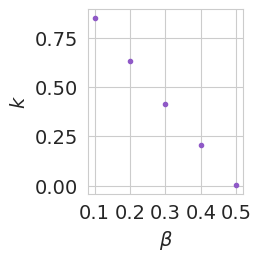

In [55]:
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax.plot(beta_arr[1:6], s, '.')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('$k$')
ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])


# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-slopeBeta_sweep.pdf')
# plt.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-EOM-Sim-slopeBeta_sweep.svg', 
#             format='svg', dpi=600)

plt.show()